In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import pandas as pd
import pickle


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


2022-12-19 11:45:23.673660: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load data

0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [2]:
def load_data(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    data0 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    data1 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data1.p", "rb" ))
    data2 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data2.p", "rb" ))
    data3 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data3.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, data0, data1, data2, data3, y

Function to standardize input features

In [3]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

Plot reults

In [4]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()
    
def get_results(h):
    test = [s[1] for s in h]
    plot = [s[0] for s in h]

    print(f'Test set results:{test}\nAverage loss:{np.average([s[0] for s in test])}\nAverage accuracy:{np.average([s[1] for s in test])}') 

    plot_stats(plot)

# Model definition

In [5]:
def train_evaluate(model_fn, train, val, test, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    # test
    print("Evaluate on test data")
    results = m.evaluate(test[0], test[1], batch_size=32)
    print("test loss, test acc:", results)
    return history, results

In [6]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.1, 
                                   random_state = 2022,
                                   stratify = metadata['label'])
    test_index = test_df.index
    x_test = x[test_index]
    y_test = y[test_index]
    for rs in n:
        trainK_df, val_df = train_test_split(train_df, 
                                   test_size = 0.15, 
                                   random_state = rs,
                                   stratify = train_df['label'])
        train_index = trainK_df.index
        val_index = val_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_val = x[val_index]
        y_val = y[val_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_val, y_val), (x_test, y_test)))
    return results

In [7]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2022-12-19 11:45:25.395461: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-19 11:45:25.396280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-19 11:45:25.496898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-19 11:45:25.496926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-19 11:45:25.498752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-19 11:45:25.498827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

In [8]:
def experiments(metadata, data, y, get_m):
    res = []
    for d in data:
        r = train_kfold(get_m, d, y, metadata)
        get_results(r)
        res.append(r)
    return res

# EMODB

In [9]:
metadata, data0, data1, data2, data3, y = load_data('emodb')
metadata

path     filename  chunk  \
0     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
1     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
2     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
3     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
4     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
...                                                 ...          ...    ...   
3740  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3741  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      1   
3742  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3743  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3744  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   

      label  actor gender  mod  
0      fear     14      f    0  
1      fear     14      f    1  
2      fear     14      f    1  
3      fear     14      f    1  
4      fear     14      f    1  
...     ...    ...    ...  ...  
3740  happy      8      f    2  
3741  happy      8      f    2  
3742  happy      8      f    2  
3743  happy      8      f    2  
3744  happy      8      f    2  

[3745 rows x 7 columns]

In [10]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape,

((3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 5))

## Without standardization

2022-12-19 11:45:27.764249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-19 11:45:27.779074: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/50


2022-12-19 11:45:28.805555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-19 11:45:28.989864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


90/90 [==============================] - 4s 22ms/step - loss: 1.5678 - accuracy: 0.2659 - val_loss: 1.5019 - val_accuracy: 0.3498
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4631 - accuracy: 0.4008 - val_loss: 1.4992 - val_accuracy: 0.3300
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4084 - accuracy: 0.4207 - val_loss: 1.4160 - val_accuracy: 0.4368
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3814 - accuracy: 0.4340 - val_loss: 1.3037 - val_accuracy: 0.4763
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2659 - accuracy: 0.5056 - val_loss: 1.2515 - val_accuracy: 0.5079
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2193 - accuracy: 0.5343 - val_loss: 1.2050 - val_accuracy: 0.5237
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1492 - accuracy: 0.5521 - val_loss: 1.1351 - val_accuracy: 0.5771
Epoch 8/50
90/90 [======

90/90 [==============================] - 1s 15ms/step - loss: 1.4336 - accuracy: 0.4610 - val_loss: 1.4388 - val_accuracy: 0.4368
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3901 - accuracy: 0.4769 - val_loss: 1.4941 - val_accuracy: 0.3656
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3678 - accuracy: 0.4755 - val_loss: 1.3399 - val_accuracy: 0.4960
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3113 - accuracy: 0.5147 - val_loss: 1.3272 - val_accuracy: 0.5099
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2819 - accuracy: 0.5296 - val_loss: 1.5152 - val_accuracy: 0.2925
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2601 - accuracy: 0.5216 - val_loss: 1.3018 - val_accuracy: 0.4763
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2373 - accuracy: 0.5383 - val_loss: 1.3088 - val_accuracy: 0.4842
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 0.8714 - accuracy: 0.6710 - val_loss: 1.1978 - val_accuracy: 0.5356
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8349 - accuracy: 0.6939 - val_loss: 1.0265 - val_accuracy: 0.6047
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8086 - accuracy: 0.7016 - val_loss: 0.9684 - val_accuracy: 0.6403
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7566 - accuracy: 0.7357 - val_loss: 0.8534 - val_accuracy: 0.6700
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7143 - accuracy: 0.7494 - val_loss: 0.8225 - val_accuracy: 0.7055
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6914 - accuracy: 0.7545 - val_loss: 0.8295 - val_accuracy: 0.7055
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6793 - accuracy: 0.7676 - val_loss: 0.8617 - val_accuracy: 0.6680
Epoch 19/50
90/90 

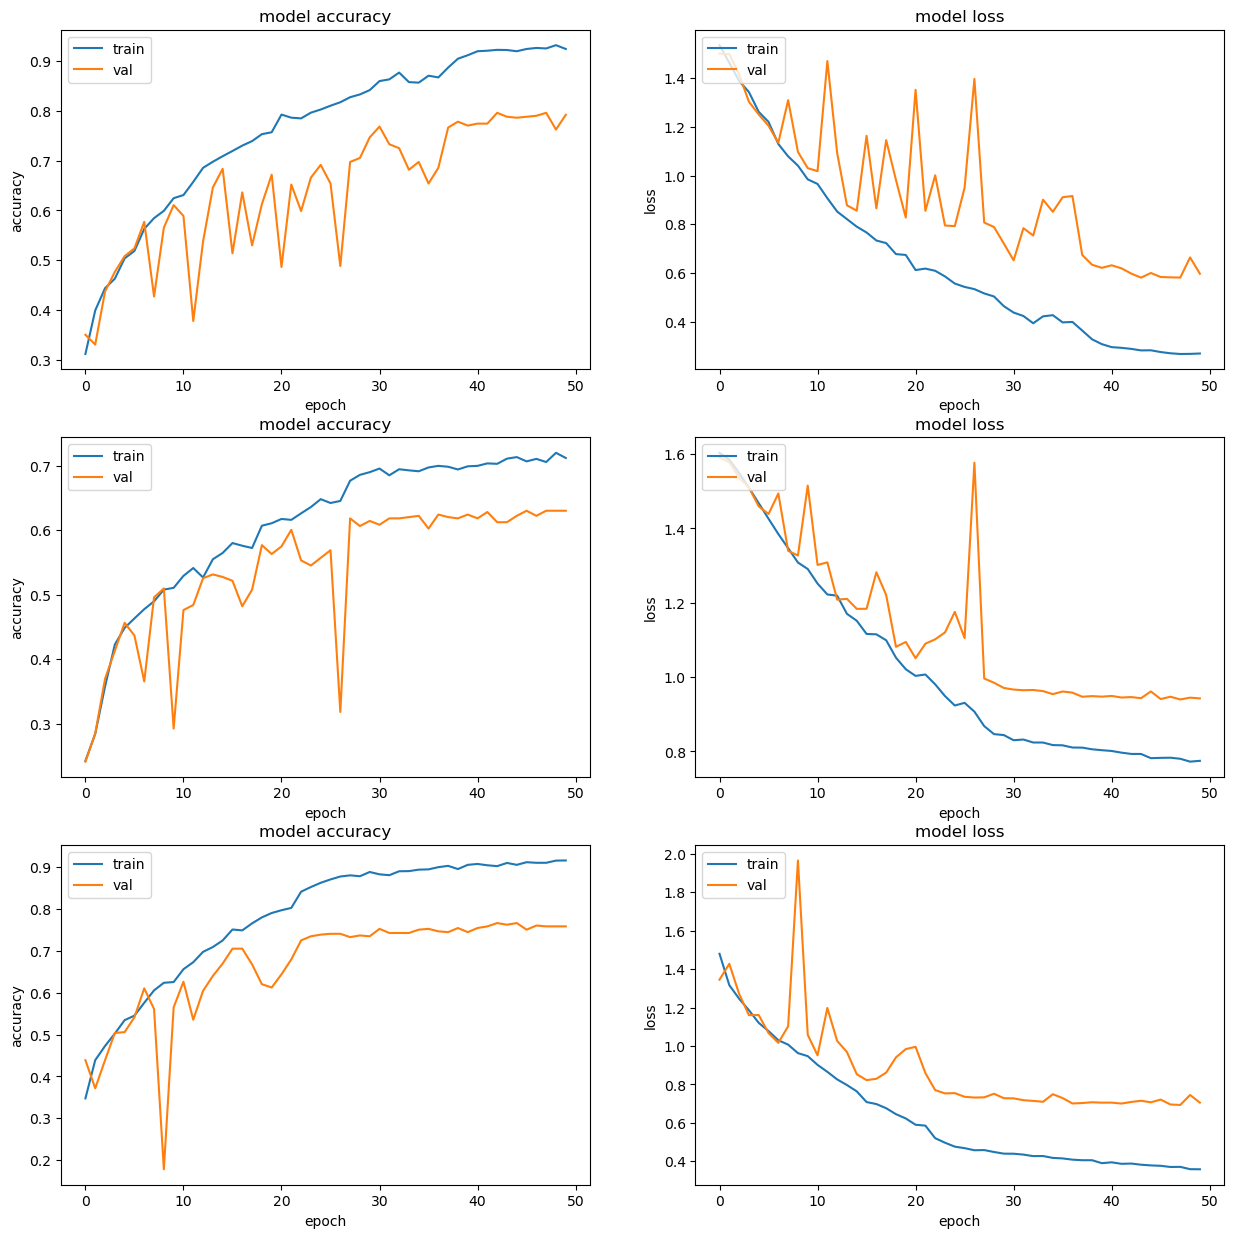

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6075 - accuracy: 0.2356 - val_loss: 1.6038 - val_accuracy: 0.2352
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6064 - accuracy: 0.2211 - val_loss: 1.6031 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6030 - accuracy: 0.2381 - val_loss: 1.6042 - val_accuracy: 0.2352
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5570 - accuracy: 0.2889 - val_loss: 1.9094 - val_accuracy: 0.2332
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4048 - accuracy: 0.3943 - val_loss: 1.9730 - val_accuracy: 0.2352
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3503 - accuracy: 0.4163 - val_loss: 2.0968 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3034 - accuracy: 0.4220 - val_loss: 2.1734 - val_accuracy: 0.2352
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.5998 - accuracy: 0.2529 - val_loss: 1.6020 - val_accuracy: 0.2352
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6052 - accuracy: 0.2259 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6023 - accuracy: 0.2344 - val_loss: 1.6020 - val_accuracy: 0.2352
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6006 - accuracy: 0.2383 - val_loss: 1.6038 - val_accuracy: 0.2352
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5839 - accuracy: 0.2779 - val_loss: 1.7782 - val_accuracy: 0.2036
Epoch 10/50
90/90 [==============================] - 1s 14ms/step - loss: 1.4121 - accuracy: 0.4085 - val_loss: 1.8949 - val_accuracy: 0.2352
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3268 - accuracy: 0.4388 - val_loss: 1.9175 - val_accuracy: 0.2352
Epoch 12/50
90/90 [===

90/90 [==============================] - 1s 15ms/step - loss: 1.3707 - accuracy: 0.4301 - val_loss: 1.8131 - val_accuracy: 0.2352
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2863 - accuracy: 0.4677 - val_loss: 1.9421 - val_accuracy: 0.1798
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2554 - accuracy: 0.4974 - val_loss: 1.7626 - val_accuracy: 0.2530
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1925 - accuracy: 0.5140 - val_loss: 1.9698 - val_accuracy: 0.1798

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1498 - accuracy: 0.5361 - val_loss: 1.9107 - val_accuracy: 0.1798
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1332 - accuracy: 0.5464 - val_loss: 1.7684 - val_accuracy: 0.2708
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.10

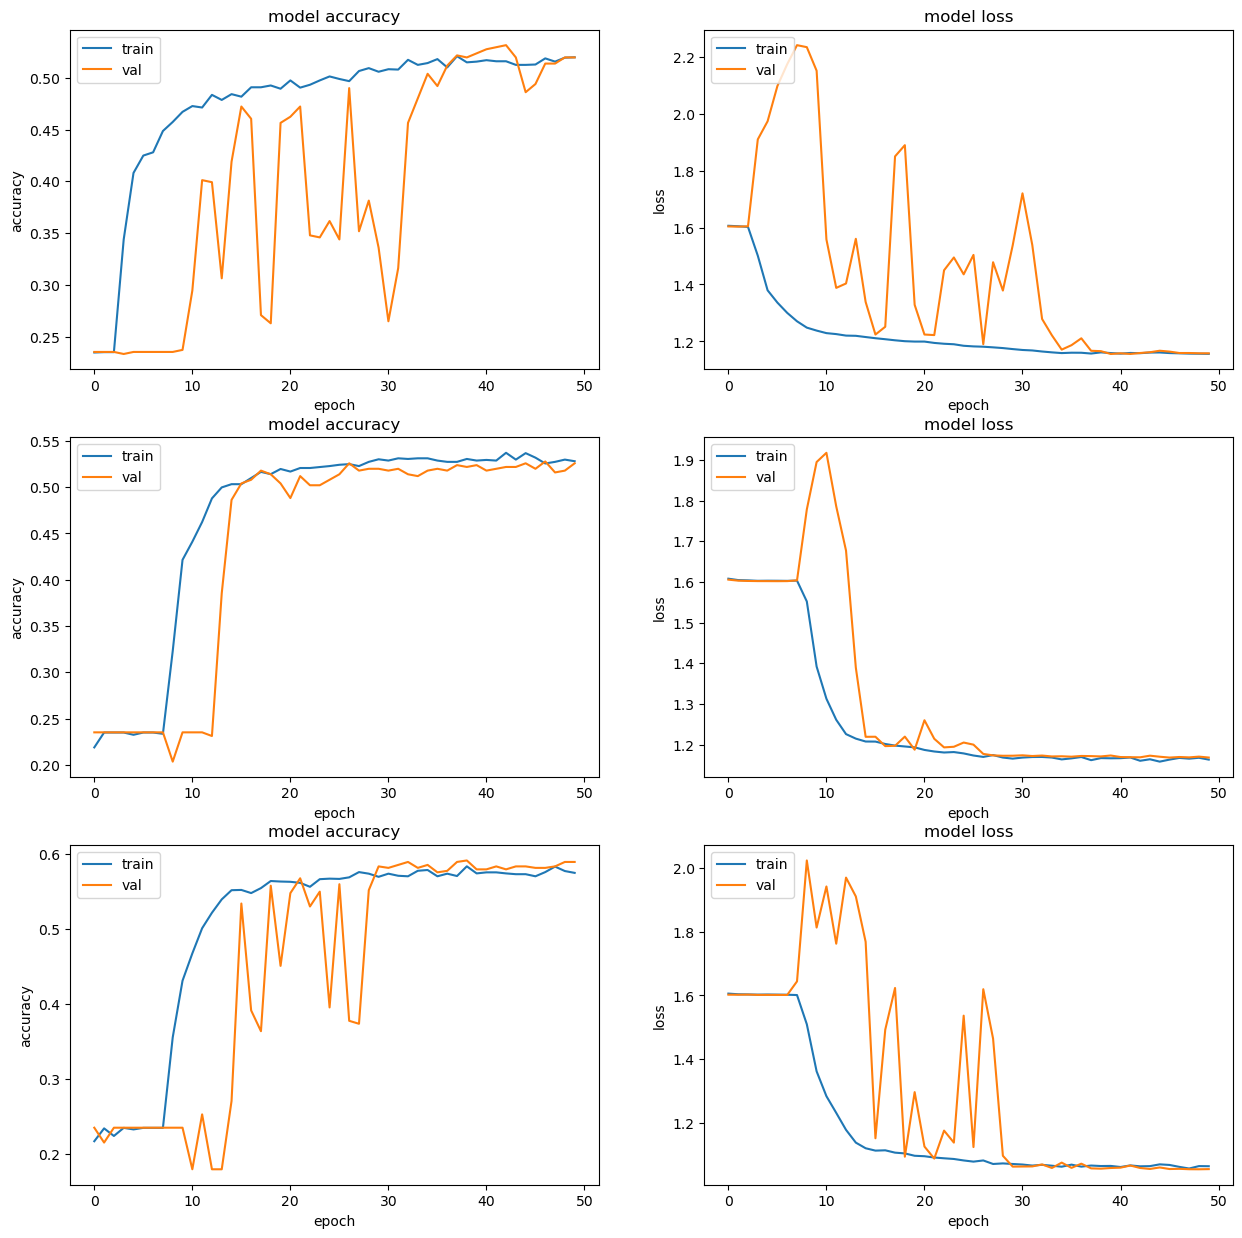

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6013 - accuracy: 0.2355 - val_loss: 1.5975 - val_accuracy: 0.3399
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5289 - accuracy: 0.3067 - val_loss: 1.5515 - val_accuracy: 0.3636
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4586 - accuracy: 0.3771 - val_loss: 1.4979 - val_accuracy: 0.3735
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4077 - accuracy: 0.4176 - val_loss: 1.5242 - val_accuracy: 0.3735
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3225 - accuracy: 0.4595 - val_loss: 1.3782 - val_accuracy: 0.4051
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2265 - accuracy: 0.5378 - val_loss: 1.2999 - val_accuracy: 0.4723
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2244 - accuracy: 0.5257 - val_loss: 1.2518 - val_accuracy: 0.5514
Epoch 8/50
90

Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6113 - accuracy: 0.7917 - val_loss: 0.7970 - val_accuracy: 0.6996
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5357 - accuracy: 0.8407 - val_loss: 0.8916 - val_accuracy: 0.6522
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5647 - accuracy: 0.8232 - val_loss: 0.7793 - val_accuracy: 0.7036
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5290 - accuracy: 0.8287 - val_loss: 0.9084 - val_accuracy: 0.6680
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5062 - accuracy: 0.8400 - val_loss: 0.9570 - val_accuracy: 0.6265
Epoch 22/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4733 - accuracy: 0.8471 - val_loss: 0.7521 - val_accuracy: 0.7213
Epoch 23/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4239 - accuracy: 0.8738 - val_loss: 0.8773 - val_accuracy: 0.6858
Epoch 

Epoch 23/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5434 - accuracy: 0.8157 - val_loss: 0.8224 - val_accuracy: 0.6779
Epoch 24/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5271 - accuracy: 0.8381 - val_loss: 1.0008 - val_accuracy: 0.6186
Epoch 25/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6121 - accuracy: 0.7919 - val_loss: 0.8293 - val_accuracy: 0.7095
Epoch 26/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5359 - accuracy: 0.8372 - val_loss: 0.7782 - val_accuracy: 0.7292
Epoch 27/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4732 - accuracy: 0.8635 - val_loss: 1.0415 - val_accuracy: 0.6344
Epoch 28/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4502 - accuracy: 0.8733 - val_loss: 2.0242 - val_accuracy: 0.4111
Epoch 29/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4928 - accuracy: 0.8558 - val_loss: 0.8278 - val_accuracy: 0.7055
Epoch 

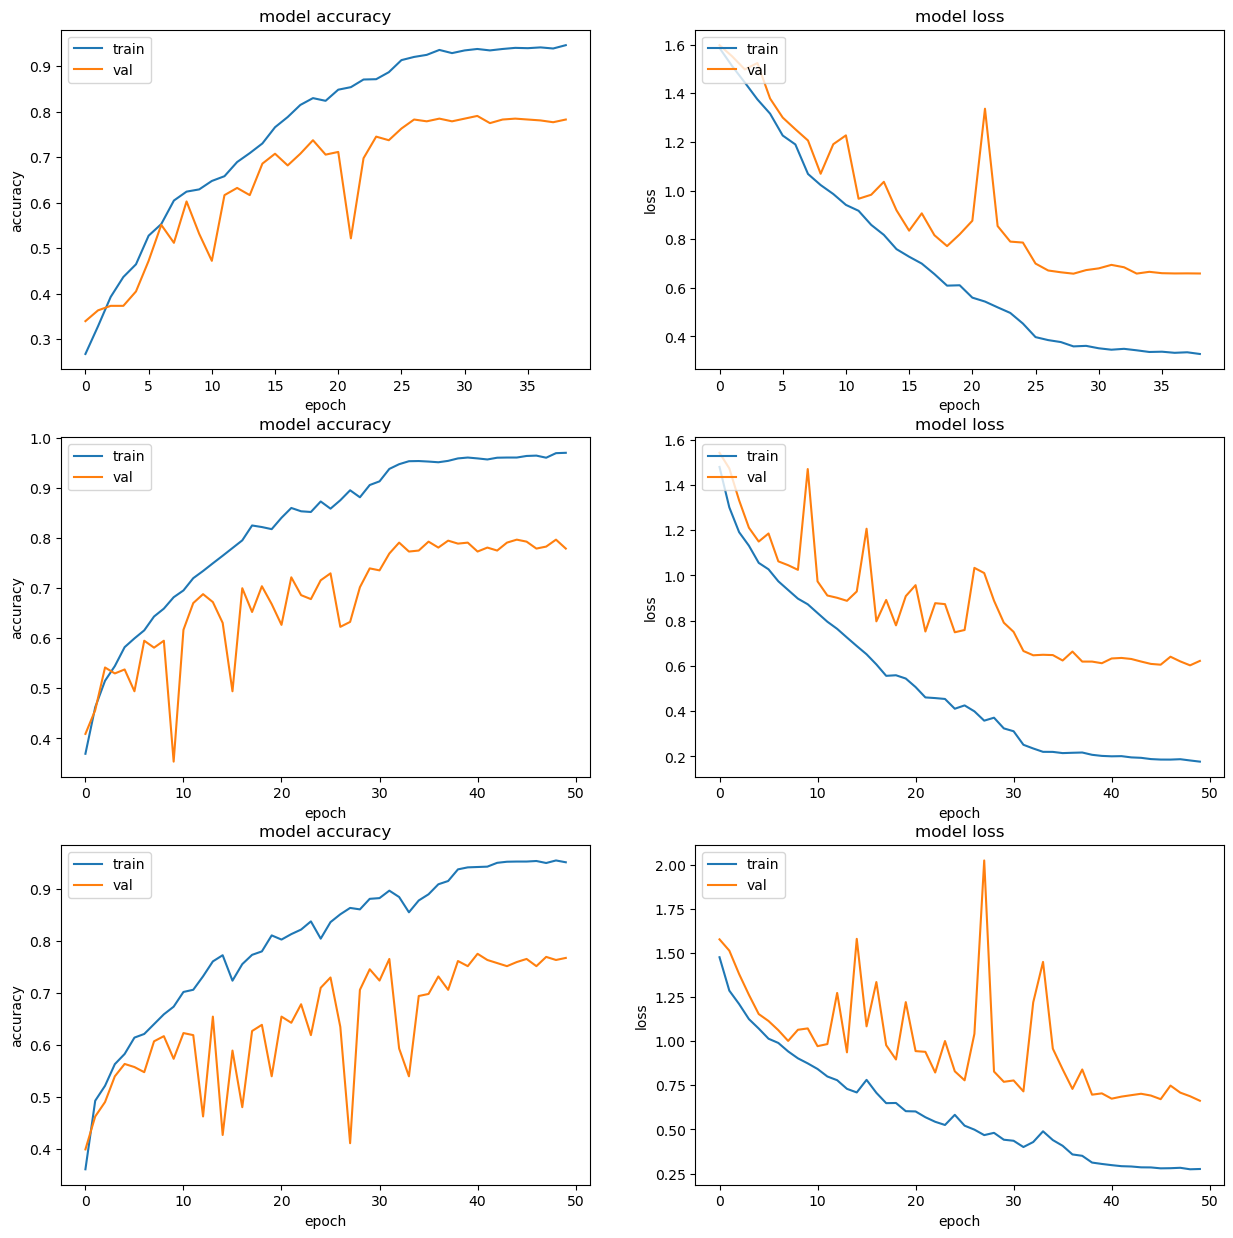

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.6034 - accuracy: 0.2520 - val_loss: 1.5909 - val_accuracy: 0.2490
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5196 - accuracy: 0.3382 - val_loss: 1.5261 - val_accuracy: 0.2846
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4338 - accuracy: 0.3726 - val_loss: 1.4277 - val_accuracy: 0.3972
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3686 - accuracy: 0.4093 - val_loss: 1.3377 - val_accuracy: 0.4209
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2936 - accuracy: 0.4697 - val_loss: 1.2880 - val_accuracy: 0.5237
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2335 - accuracy: 0.5445 - val_loss: 1.2241 - val_accuracy: 0.5573
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1834 - accuracy: 0.5710 - val_loss: 1.2174 - val_accuracy: 0.5474
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.0540 - accuracy: 0.6860 - val_loss: 1.1369 - val_accuracy: 0.6344
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0231 - accuracy: 0.6953 - val_loss: 1.1584 - val_accuracy: 0.5771
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9932 - accuracy: 0.7084 - val_loss: 1.1081 - val_accuracy: 0.6047
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9788 - accuracy: 0.7082 - val_loss: 1.0754 - val_accuracy: 0.6304
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9073 - accuracy: 0.7489 - val_loss: 1.0434 - val_accuracy: 0.6561
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8776 - accuracy: 0.7562 - val_loss: 1.1064 - val_accuracy: 0.6186
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8771 - accuracy: 0.7395 - val_loss: 1.0296 - val_accuracy: 0.6700
Epoch 20/50
90/90 

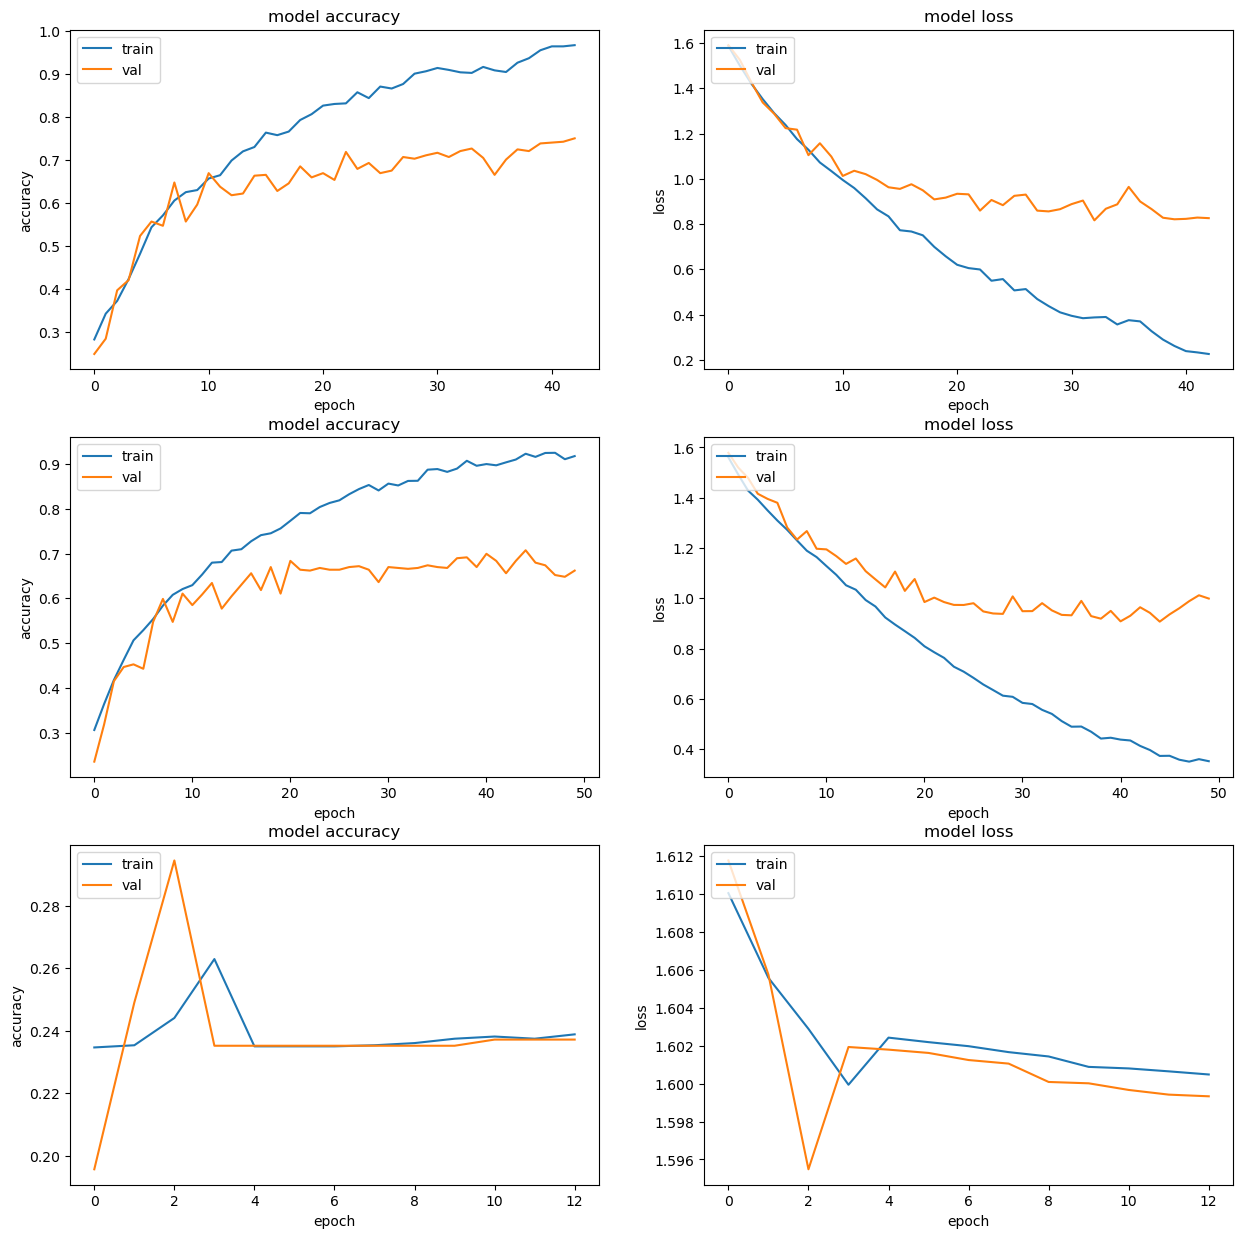

In [11]:
emodb1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [12]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6135 - accuracy: 0.2188 - val_loss: 1.6044 - val_accuracy: 0.2609
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6056 - accuracy: 0.2347 - val_loss: 1.6028 - val_accuracy: 0.2510
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6055 - accuracy: 0.2290 - val_loss: 1.6033 - val_accuracy: 0.2352
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6042 - accuracy: 0.2269 - val_loss: 1.5866 - val_accuracy: 0.2787
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5878 - accuracy: 0.2816 - val_loss: 1.5647 - val_accuracy: 0.3024
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5560 - accuracy: 0.3046 - val_loss: 1.5266 - val_accuracy: 0.4170
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5152 - accuracy: 0.3870 - val_loss: 1.4713 - val_accuracy: 0.4170
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.6022 - accuracy: 0.2290 - val_loss: 1.6020 - val_accuracy: 0.2352
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6003 - accuracy: 0.2388 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5989 - accuracy: 0.2409 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6038 - accuracy: 0.2338 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6000 - accuracy: 0.2448 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6042 - accuracy: 0.2360 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6035 - accuracy: 0.2247 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 0.7160 - accuracy: 0.7691 - val_loss: 1.0044 - val_accuracy: 0.6028
Epoch 32/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7089 - accuracy: 0.7713 - val_loss: 1.0294 - val_accuracy: 0.5751
Epoch 33/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6752 - accuracy: 0.7923 - val_loss: 1.0468 - val_accuracy: 0.5870
Epoch 34/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6573 - accuracy: 0.8079 - val_loss: 1.0009 - val_accuracy: 0.5909
Epoch 35/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6279 - accuracy: 0.8037 - val_loss: 1.0609 - val_accuracy: 0.5711
Epoch 36/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6065 - accuracy: 0.8227 - val_loss: 0.9741 - val_accuracy: 0.6245
Epoch 37/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5885 - accuracy: 0.8273 - val_loss: 1.0244 - val_accuracy: 0.5771
Epoch 38/50
90/90 

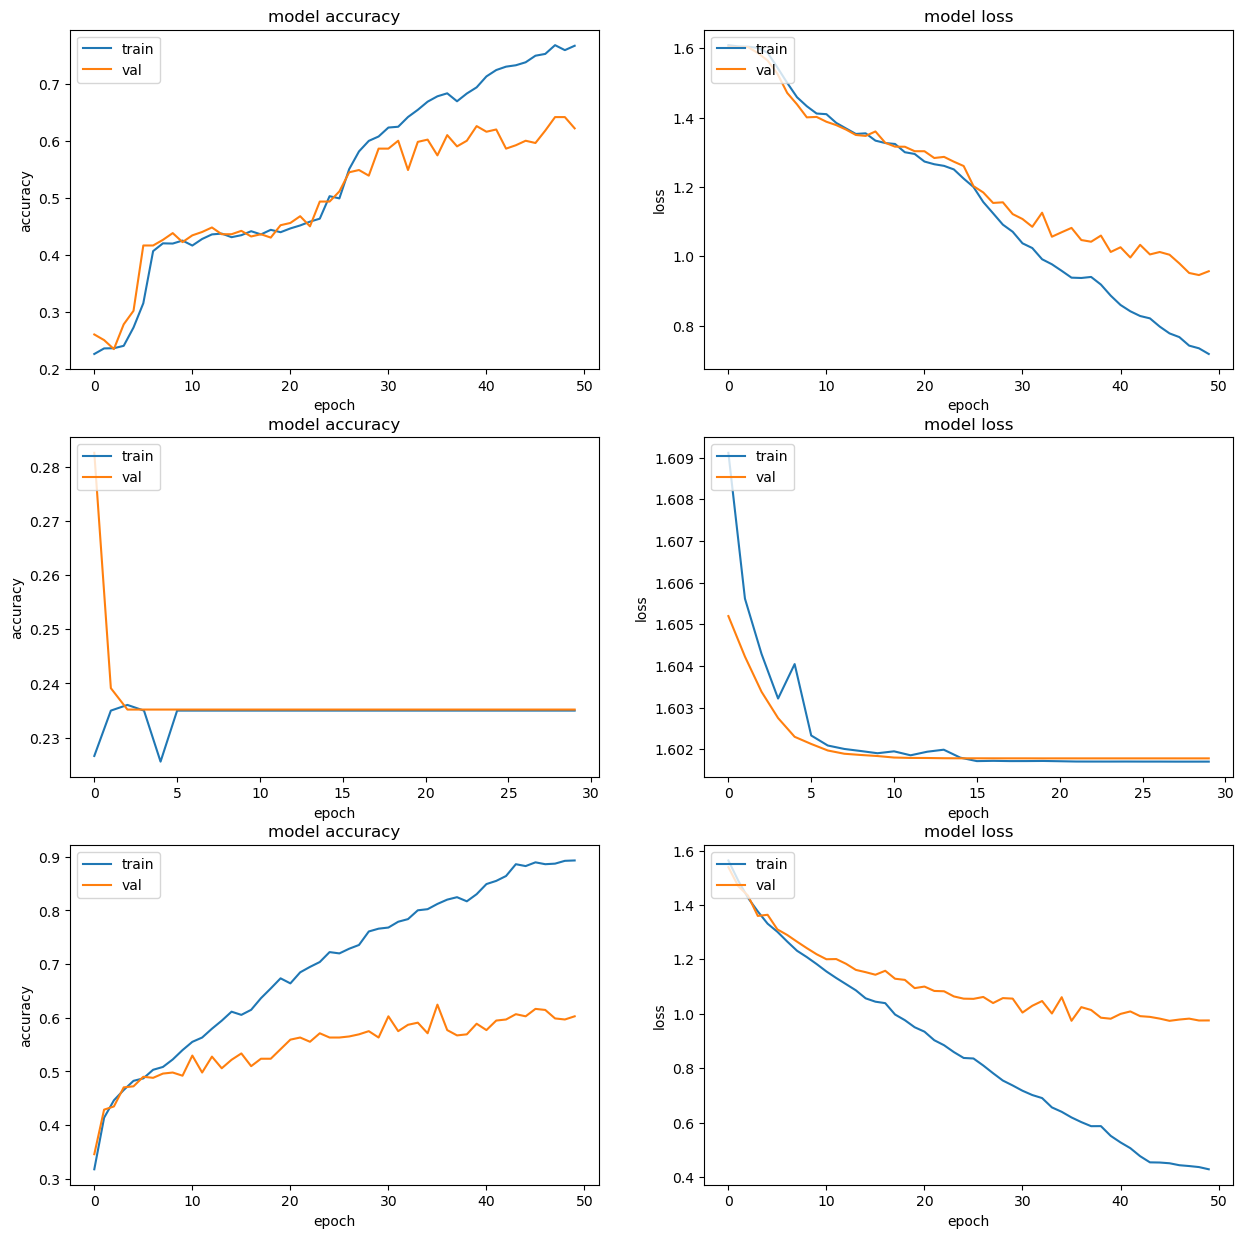

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5673 - accuracy: 0.2640 - val_loss: 1.4445 - val_accuracy: 0.4209
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4546 - accuracy: 0.4390 - val_loss: 1.4150 - val_accuracy: 0.4545
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4255 - accuracy: 0.4457 - val_loss: 1.3512 - val_accuracy: 0.5099
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3909 - accuracy: 0.4521 - val_loss: 1.3309 - val_accuracy: 0.4802
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3542 - accuracy: 0.4581 - val_loss: 1.2676 - val_accuracy: 0.5395
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3036 - accuracy: 0.4870 - val_loss: 1.2729 - val_accuracy: 0.4921
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2791 - accuracy: 0.5058 - val_loss: 1.2256 - val_accuracy: 0.5178
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2134 - accuracy: 0.5038 - val_loss: 1.2301 - val_accuracy: 0.5000
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1651 - accuracy: 0.5202 - val_loss: 1.1883 - val_accuracy: 0.5356
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1056 - accuracy: 0.5792 - val_loss: 1.1608 - val_accuracy: 0.5514
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0746 - accuracy: 0.5954 - val_loss: 1.1453 - val_accuracy: 0.5435
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0112 - accuracy: 0.6338 - val_loss: 1.1501 - val_accuracy: 0.5455
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0268 - accuracy: 0.6185 - val_loss: 1.0748 - val_accuracy: 0.6008
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9627 - accuracy: 0.6460 - val_loss: 1.0532 - val_accuracy: 0.5968
Epoch 14/50
90/90 [=

Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1211 - accuracy: 0.5885 - val_loss: 1.1920 - val_accuracy: 0.5178
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1033 - accuracy: 0.5842 - val_loss: 1.1731 - val_accuracy: 0.5474
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0811 - accuracy: 0.5975 - val_loss: 1.1319 - val_accuracy: 0.5771
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0465 - accuracy: 0.6196 - val_loss: 1.1015 - val_accuracy: 0.5593
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0279 - accuracy: 0.6169 - val_loss: 1.1166 - val_accuracy: 0.5514
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0110 - accuracy: 0.6173 - val_loss: 1.0519 - val_accuracy: 0.5791
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9589 - accuracy: 0.6533 - val_loss: 1.0714 - val_accuracy: 0.5711
Epoch 

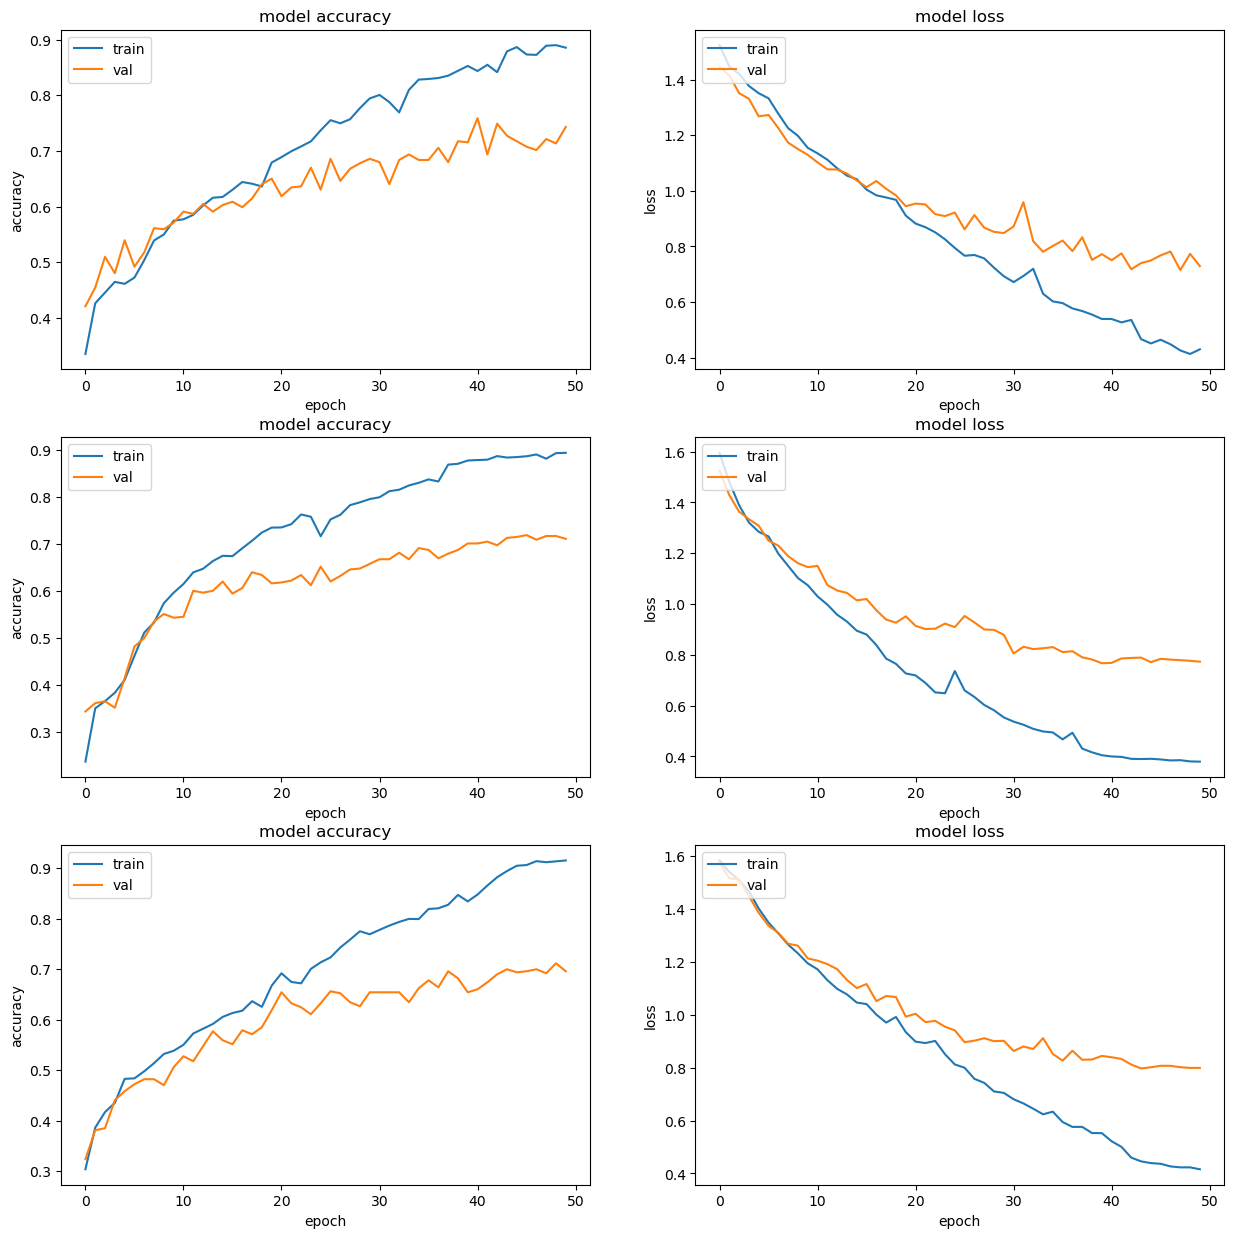

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5437 - accuracy: 0.2494 - val_loss: 1.4068 - val_accuracy: 0.3636
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4028 - accuracy: 0.3910 - val_loss: 1.3922 - val_accuracy: 0.4229
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3945 - accuracy: 0.4055 - val_loss: 1.3382 - val_accuracy: 0.4447
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3348 - accuracy: 0.4372 - val_loss: 1.2933 - val_accuracy: 0.4684
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2572 - accuracy: 0.4778 - val_loss: 1.2159 - val_accuracy: 0.5237
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2290 - accuracy: 0.4986 - val_loss: 1.2534 - val_accuracy: 0.4941
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1905 - accuracy: 0.5072 - val_loss: 1.1433 - val_accuracy: 0.5593
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 0.7719 - accuracy: 0.7122 - val_loss: 0.8474 - val_accuracy: 0.6858
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7311 - accuracy: 0.7443 - val_loss: 0.8636 - val_accuracy: 0.6858
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7186 - accuracy: 0.7467 - val_loss: 0.8288 - val_accuracy: 0.6779
Epoch 22/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6983 - accuracy: 0.7547 - val_loss: 0.8818 - val_accuracy: 0.6739
Epoch 23/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6556 - accuracy: 0.7793 - val_loss: 0.8444 - val_accuracy: 0.6917
Epoch 24/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6199 - accuracy: 0.7937 - val_loss: 0.8167 - val_accuracy: 0.7174
Epoch 25/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6400 - accuracy: 0.7823 - val_loss: 0.8652 - val_accuracy: 0.6660
Epoch 26/50
90/90 

90/90 [==============================] - 1s 15ms/step - loss: 0.9299 - accuracy: 0.6769 - val_loss: 1.0445 - val_accuracy: 0.5968
Epoch 26/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9287 - accuracy: 0.6746 - val_loss: 1.0148 - val_accuracy: 0.6383
Epoch 27/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8822 - accuracy: 0.7112 - val_loss: 1.0075 - val_accuracy: 0.6285
Epoch 28/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8521 - accuracy: 0.7347 - val_loss: 0.9892 - val_accuracy: 0.6364
Epoch 29/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8435 - accuracy: 0.7464 - val_loss: 1.0032 - val_accuracy: 0.6166
Epoch 30/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8165 - accuracy: 0.7488 - val_loss: 0.9831 - val_accuracy: 0.6443
Epoch 31/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7941 - accuracy: 0.7652 - val_loss: 0.9768 - val_accuracy: 0.6304
Epoch 32/50
90/90 

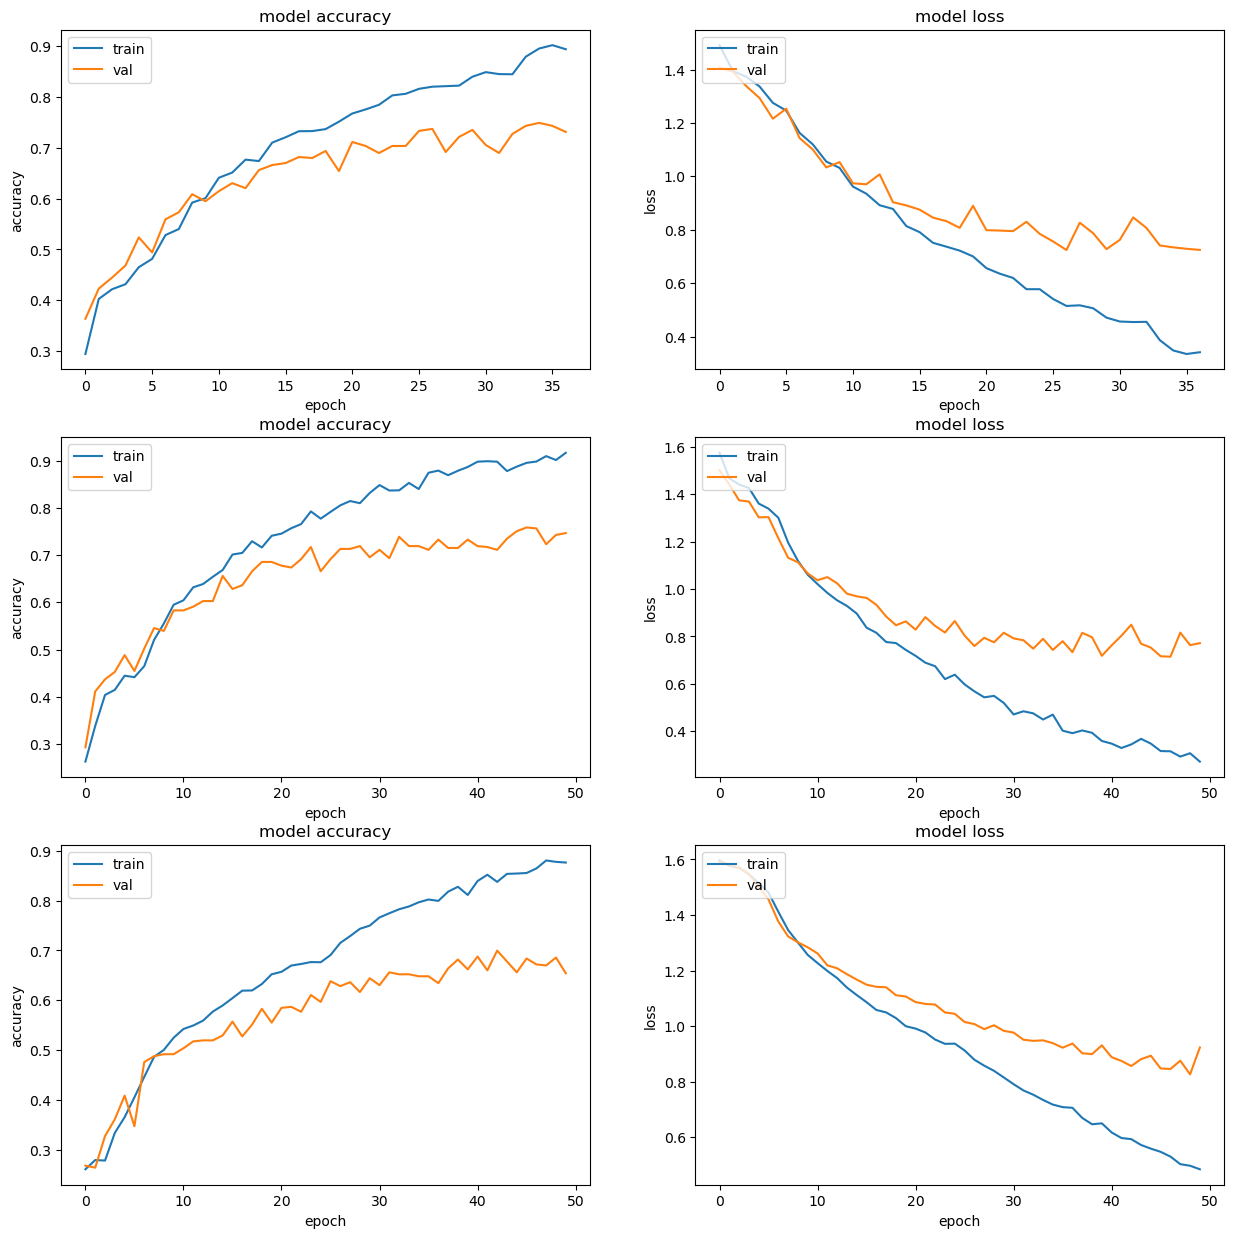

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.6022 - accuracy: 0.2643 - val_loss: 1.5516 - val_accuracy: 0.3399
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5417 - accuracy: 0.3833 - val_loss: 1.5151 - val_accuracy: 0.4130
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5059 - accuracy: 0.4279 - val_loss: 1.4895 - val_accuracy: 0.3992
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4688 - accuracy: 0.4368 - val_loss: 1.4545 - val_accuracy: 0.4150
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4322 - accuracy: 0.4650 - val_loss: 1.4062 - val_accuracy: 0.4960
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3937 - accuracy: 0.4861 - val_loss: 1.3648 - val_accuracy: 0.5040
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3617 - accuracy: 0.5121 - val_loss: 1.3389 - val_accuracy: 0.4960
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.1959 - accuracy: 0.5086 - val_loss: 1.2125 - val_accuracy: 0.5178
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1634 - accuracy: 0.5354 - val_loss: 1.1704 - val_accuracy: 0.5296
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1187 - accuracy: 0.5677 - val_loss: 1.1467 - val_accuracy: 0.5553
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0991 - accuracy: 0.5496 - val_loss: 1.1273 - val_accuracy: 0.5415
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0470 - accuracy: 0.5806 - val_loss: 1.0933 - val_accuracy: 0.5711
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0217 - accuracy: 0.5960 - val_loss: 1.0541 - val_accuracy: 0.5889
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9648 - accuracy: 0.6231 - val_loss: 1.0481 - val_accuracy: 0.5889
Epoch 13/50
90/90 [==

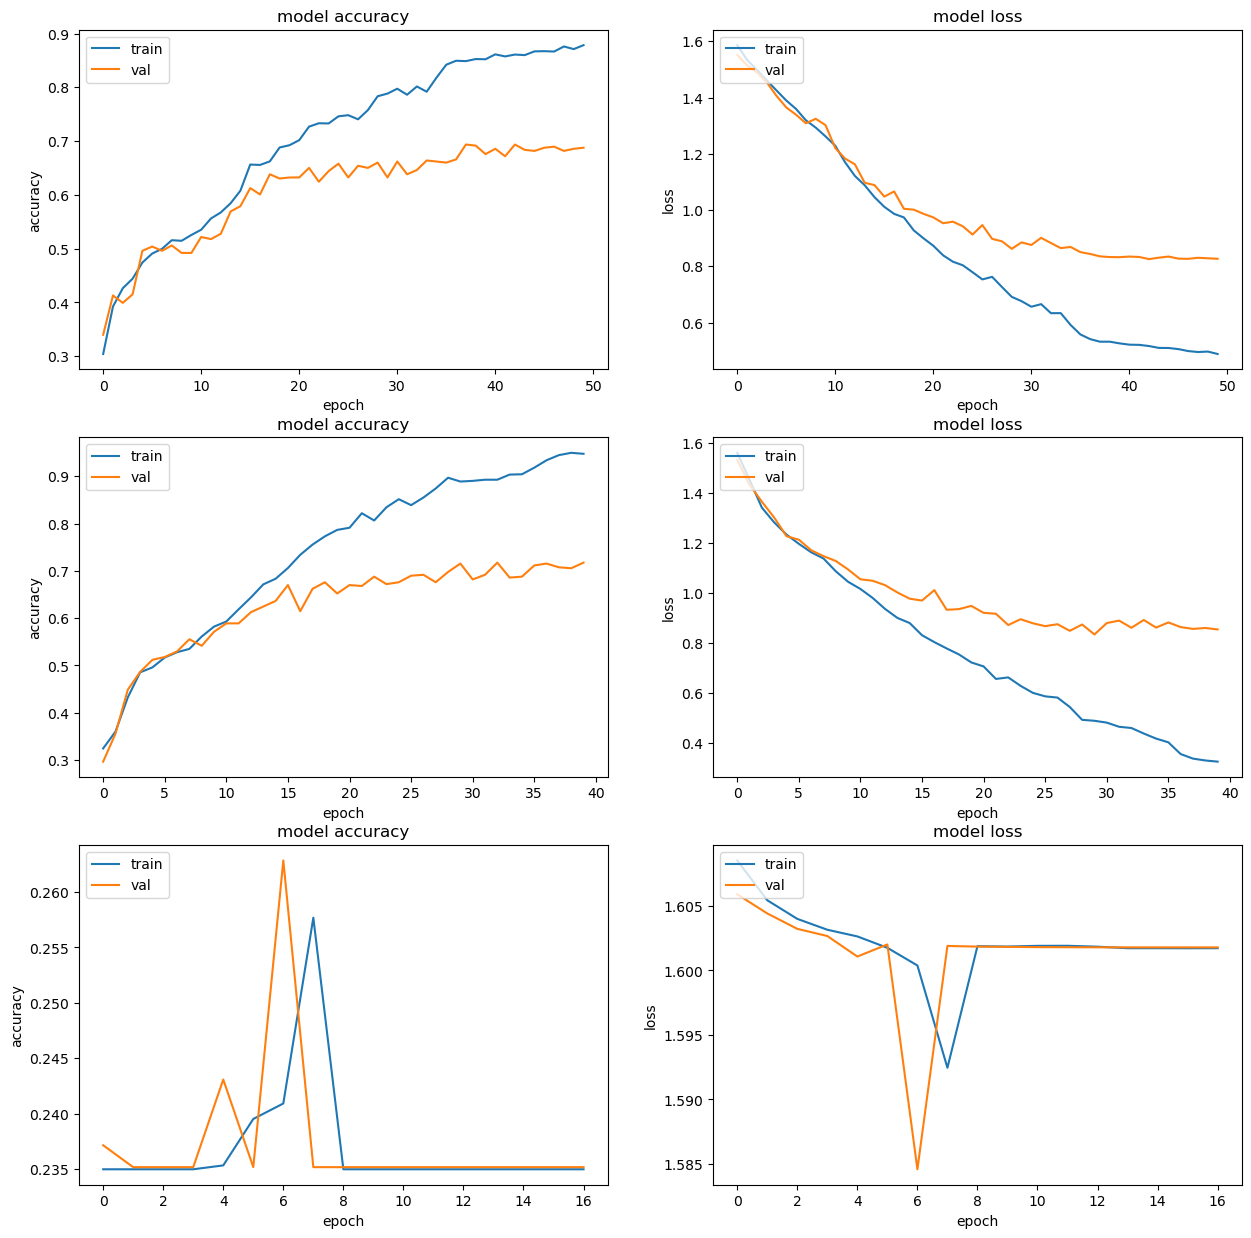

In [13]:
emodb2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# EMOVO

In [14]:
metadata, data0, data1, data2, data3, y = load_data('emovo')
metadata

path       filename  chunk  \
0     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
1     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      1   
2     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
3     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      1   
4     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
...                                                 ...            ...    ...   
4926  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4927  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4928  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4929  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4930  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   

      label actor gender  mod  
0     happy    m3      m    0  
1     happy    m3      m    0  
2     happy    m3      m    1  
3     happy    m3      m    1  
4     happy    m3      m    1  
...     ...   ...    ...  ...  
4926   fear    m2      m    1  
4927   fear    m2      m    2  
4928   fear    m2      m    2  
4929   fear    m2      m    2  
4930   fear    m2      m    2  

[4931 rows x 7 columns]

In [15]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 5))

## Without standardization

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.5985 - accuracy: 0.2330 - val_loss: 1.5967 - val_accuracy: 0.2658
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5710 - accuracy: 0.2783 - val_loss: 1.5678 - val_accuracy: 0.2958
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5780 - accuracy: 0.2659 - val_loss: 1.5684 - val_accuracy: 0.2928
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5709 - accuracy: 0.2660 - val_loss: 1.5672 - val_accuracy: 0.2883
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5590 - accuracy: 0.2970 - val_loss: 1.5564 - val_accuracy: 0.3033
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5573 - accuracy: 0.2901 - val_loss: 1.5817 - val_accuracy: 0.1922
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5720 - accuracy: 0.2498 - val_loss: 1.5724 - val_accuracy: 0.2748

118/118 [==============================] - 2s 15ms/step - loss: 0.8563 - accuracy: 0.6719 - val_loss: 1.0721 - val_accuracy: 0.5706
Epoch 41/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8635 - accuracy: 0.6785 - val_loss: 1.0670 - val_accuracy: 0.5646
Epoch 42/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8593 - accuracy: 0.6727 - val_loss: 1.0703 - val_accuracy: 0.5661
Epoch 43/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8573 - accuracy: 0.6693 - val_loss: 1.0710 - val_accuracy: 0.5721
Epoch 44/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8430 - accuracy: 0.6862 - val_loss: 1.0600 - val_accuracy: 0.5616
Epoch 45/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8468 - accuracy: 0.6766 - val_loss: 1.0636 - val_accuracy: 0.5601
Epoch 46/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8539 - accuracy: 0.6700 - val_loss: 1.0606 - val_accuracy: 0.5826
Epoc

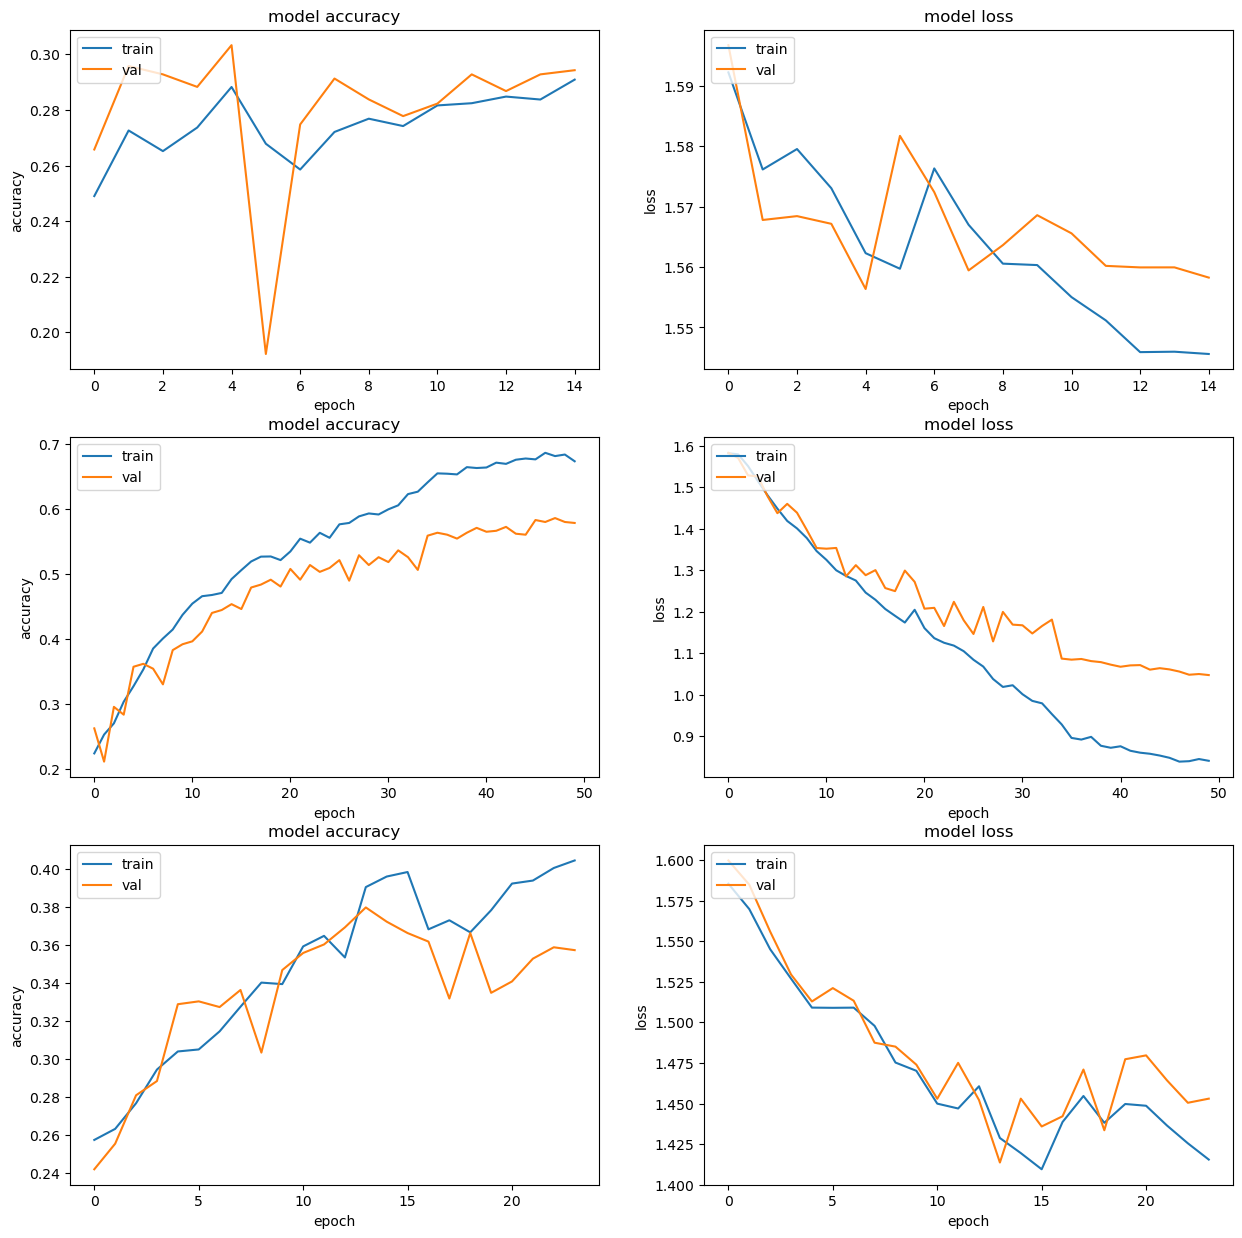

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.6093 - accuracy: 0.2179 - val_loss: 1.6079 - val_accuracy: 0.2192
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5998 - accuracy: 0.2279 - val_loss: 1.6201 - val_accuracy: 0.1877
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5601 - accuracy: 0.2716 - val_loss: 1.6244 - val_accuracy: 0.1877
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5517 - accuracy: 0.2785 - val_loss: 1.6313 - val_accuracy: 0.1877
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5243 - accuracy: 0.3172 - val_loss: 1.6322 - val_accuracy: 0.1937
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5088 - accuracy: 0.3198 - val_loss: 1.6295 - val_accuracy: 0.1997
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4728 - accuracy: 0.3517 - val_loss: 2.0813 - val_accuracy: 0.2192

118/118 [==============================] - 2s 14ms/step - loss: 1.6092 - accuracy: 0.2111 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 10/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6084 - accuracy: 0.2177 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 11/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2131 - val_loss: 1.6078 - val_accuracy: 0.2192

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6076 - accuracy: 0.2180 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 13/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6091 - accuracy: 0.2136 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 14/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6080 - accuracy: 0.2183 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 15/50
118/118 [==============================] - 2s 14ms/ste

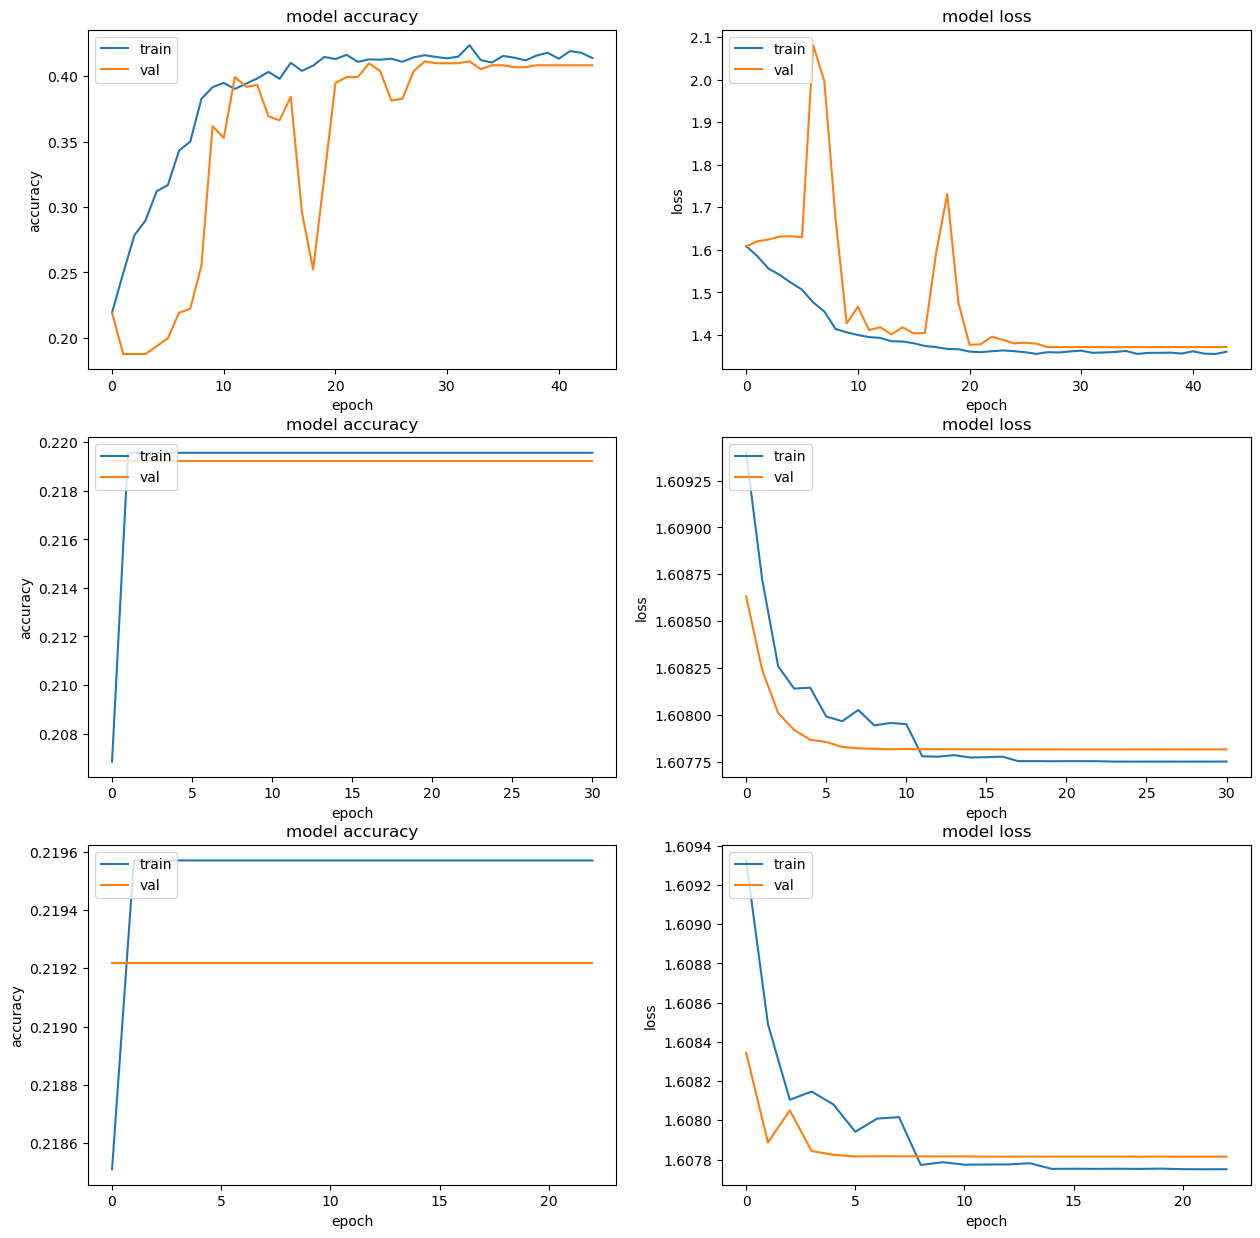

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.6014 - accuracy: 0.2544 - val_loss: 1.6003 - val_accuracy: 0.2538
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5425 - accuracy: 0.2945 - val_loss: 1.5574 - val_accuracy: 0.3468
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4975 - accuracy: 0.3400 - val_loss: 1.4841 - val_accuracy: 0.3498
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4142 - accuracy: 0.3710 - val_loss: 1.3909 - val_accuracy: 0.4219
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3282 - accuracy: 0.4275 - val_loss: 1.3434 - val_accuracy: 0.4099
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.2724 - accuracy: 0.4859 - val_loss: 1.3478 - val_accuracy: 0.4024
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.2250 - accuracy: 0.5096 - val_loss: 1.2548 - val_accuracy: 0.4655

118/118 [==============================] - 2s 14ms/step - loss: 1.6070 - accuracy: 0.2233 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6077 - accuracy: 0.2249 - val_loss: 1.6079 - val_accuracy: 0.2192
Epoch 8/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6077 - accuracy: 0.2223 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 9/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6075 - accuracy: 0.2218 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 10/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2143 - val_loss: 1.6078 - val_accuracy: 0.2192

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6073 - accuracy: 0.2243 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 12/50
118/118 [==============================] - 2s 14ms/step -

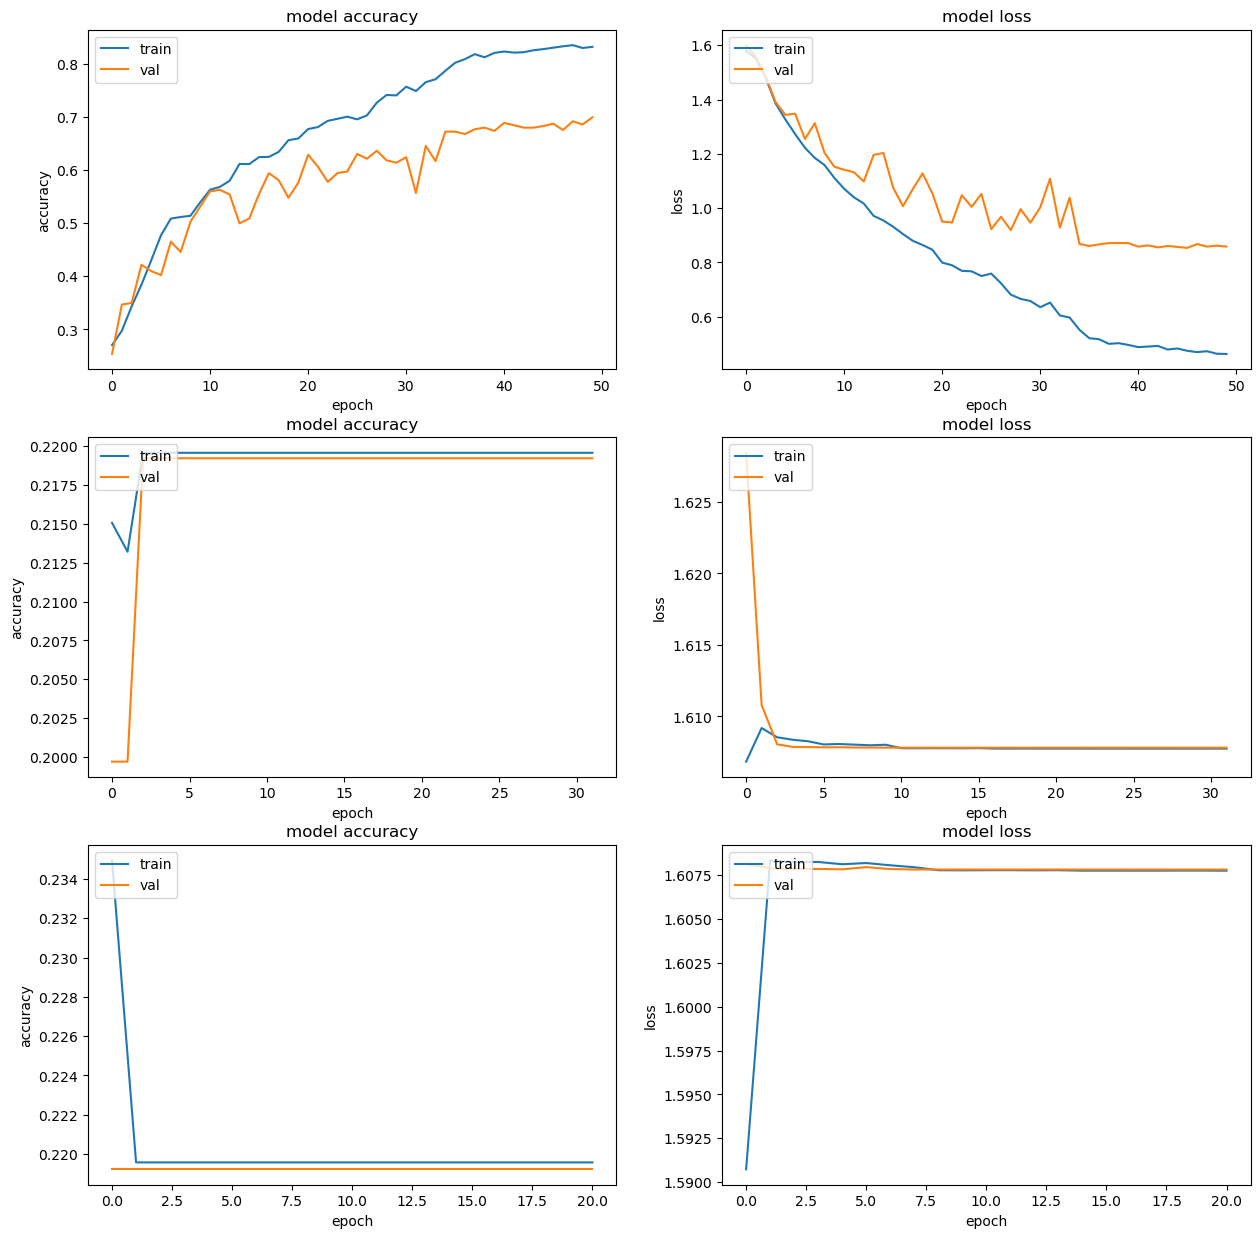

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.6100 - accuracy: 0.1994 - val_loss: 1.6237 - val_accuracy: 0.2192
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5824 - accuracy: 0.2514 - val_loss: 1.6305 - val_accuracy: 0.2282
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5639 - accuracy: 0.2947 - val_loss: 1.5725 - val_accuracy: 0.2492
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5399 - accuracy: 0.3157 - val_loss: 1.5861 - val_accuracy: 0.2477
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5329 - accuracy: 0.3238 - val_loss: 1.5353 - val_accuracy: 0.3078
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5161 - accuracy: 0.3251 - val_loss: 1.5155 - val_accuracy: 0.3243
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4757 - accuracy: 0.3504 - val_loss: 1.4877 - val_accuracy: 0.3168

118/118 [==============================] - 2s 15ms/step - loss: 1.5254 - accuracy: 0.3050 - val_loss: 1.5168 - val_accuracy: 0.3108
Epoch 10/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5090 - accuracy: 0.3152 - val_loss: 1.5057 - val_accuracy: 0.3243
Epoch 11/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5010 - accuracy: 0.3341 - val_loss: 1.4972 - val_accuracy: 0.3228
Epoch 12/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4918 - accuracy: 0.3172 - val_loss: 1.4817 - val_accuracy: 0.3423
Epoch 13/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4863 - accuracy: 0.3374 - val_loss: 1.5108 - val_accuracy: 0.3213
Epoch 14/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4811 - accuracy: 0.3496 - val_loss: 1.5093 - val_accuracy: 0.3123
Epoch 15/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4885 - accuracy: 0.3361 - val_loss: 1.5065 - val_accuracy: 0.3514
Epoc

118/118 [==============================] - 2s 15ms/step - loss: 0.6757 - accuracy: 0.7543 - val_loss: 1.1747 - val_accuracy: 0.5270
Epoch 33/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6871 - accuracy: 0.7451 - val_loss: 1.1753 - val_accuracy: 0.5330
Epoch 34/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6590 - accuracy: 0.7702 - val_loss: 1.1705 - val_accuracy: 0.5390
Epoch 35/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6719 - accuracy: 0.7663 - val_loss: 1.1711 - val_accuracy: 0.5225
Epoch 36/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6678 - accuracy: 0.7621 - val_loss: 1.1662 - val_accuracy: 0.5300
Epoch 37/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6517 - accuracy: 0.7630 - val_loss: 1.1630 - val_accuracy: 0.5270
Epoch 38/50
118/118 [==============================] - 2s 15ms/step - loss: 0.6597 - accuracy: 0.7648 - val_loss: 1.1554 - val_accuracy: 0.5405
Epoc

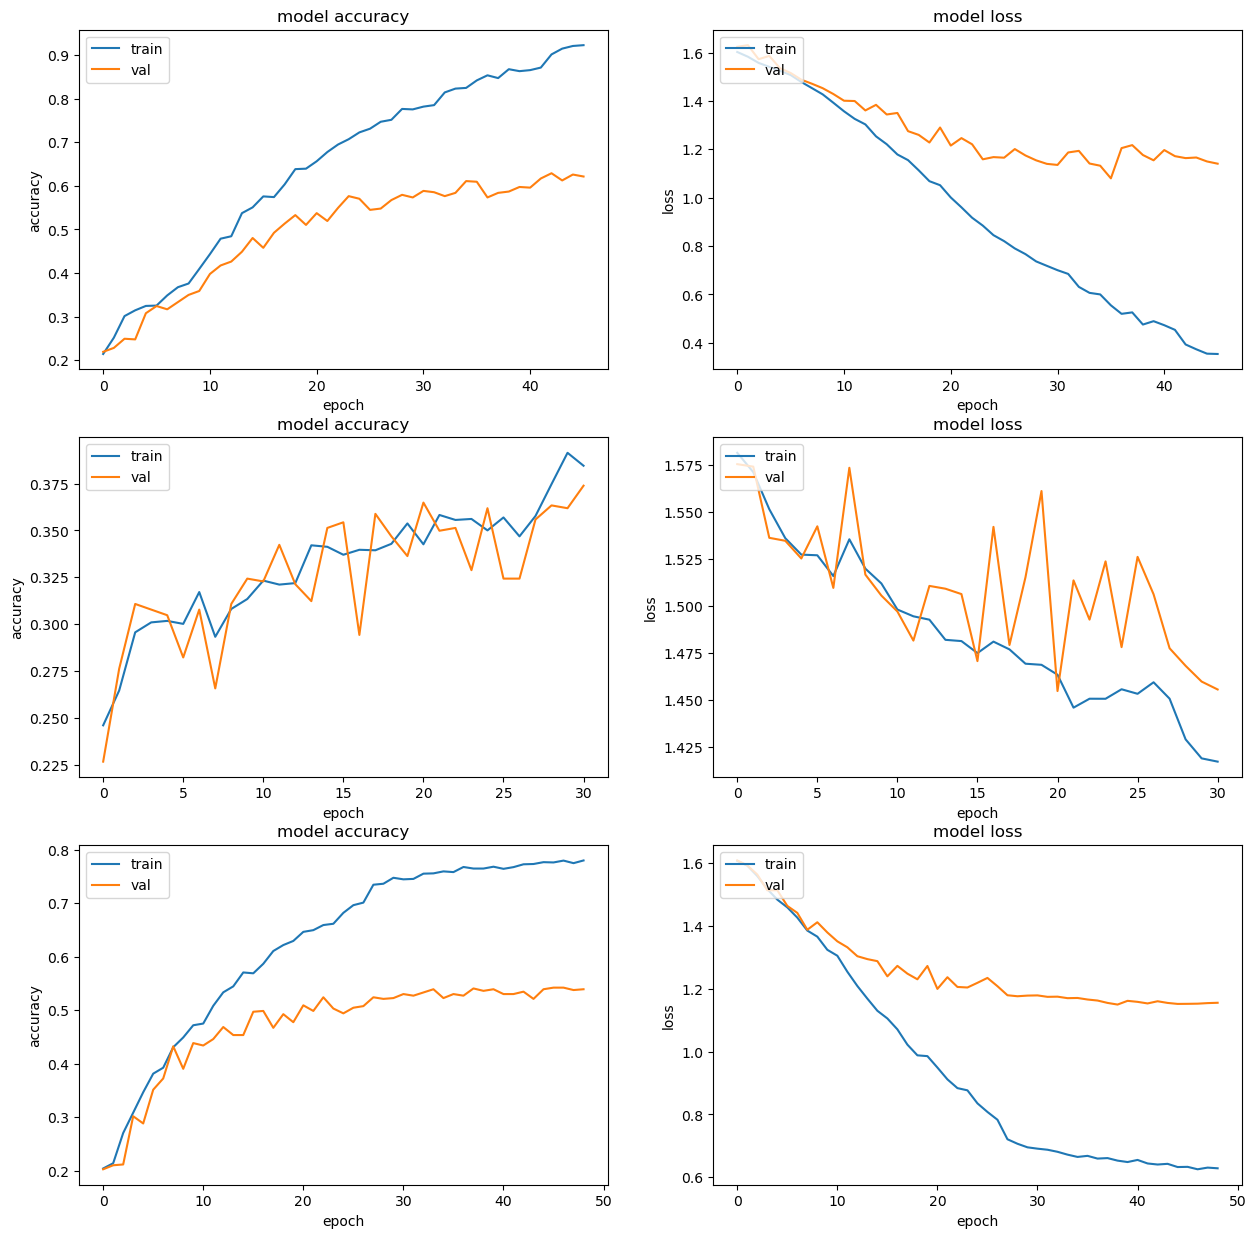

In [16]:
emovo1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [17]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.6122 - accuracy: 0.2029 - val_loss: 1.6061 - val_accuracy: 0.2042
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6087 - accuracy: 0.2128 - val_loss: 1.6096 - val_accuracy: 0.2042
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6071 - accuracy: 0.2264 - val_loss: 1.6050 - val_accuracy: 0.2267
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6031 - accuracy: 0.2366 - val_loss: 1.5927 - val_accuracy: 0.2357
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5973 - accuracy: 0.2188 - val_loss: 1.5991 - val_accuracy: 0.2357
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6013 - accuracy: 0.2382 - val_loss: 1.5967 - val_accuracy: 0.2432
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5985 - accuracy: 0.2368 - val_loss: 1.5916 - val_accuracy: 0.2432

Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4897 - accuracy: 0.3463 - val_loss: 1.4975 - val_accuracy: 0.3604
Epoch 8/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4657 - accuracy: 0.3640 - val_loss: 1.4816 - val_accuracy: 0.3664
Epoch 9/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4402 - accuracy: 0.3960 - val_loss: 1.4411 - val_accuracy: 0.3829
Epoch 10/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4121 - accuracy: 0.4304 - val_loss: 1.4462 - val_accuracy: 0.3844
Epoch 11/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3987 - accuracy: 0.4227 - val_loss: 1.3939 - val_accuracy: 0.4339
Epoch 12/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3682 - accuracy: 0.4555 - val_loss: 1.4000 - val_accuracy: 0.4174
Epoch 13/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3244 - accuracy: 0.4777 - val_loss: 1.3735 - val_accuracy: 0.

118/118 [==============================] - 2s 15ms/step - loss: 1.3491 - accuracy: 0.4320 - val_loss: 1.3616 - val_accuracy: 0.4084
Epoch 13/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3406 - accuracy: 0.4268 - val_loss: 1.3544 - val_accuracy: 0.3889
Epoch 14/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3148 - accuracy: 0.4521 - val_loss: 1.3210 - val_accuracy: 0.4234
Epoch 15/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3139 - accuracy: 0.4427 - val_loss: 1.3156 - val_accuracy: 0.4084
Epoch 16/50
118/118 [==============================] - 2s 15ms/step - loss: 1.2963 - accuracy: 0.4606 - val_loss: 1.2980 - val_accuracy: 0.4249
Epoch 17/50
118/118 [==============================] - 2s 15ms/step - loss: 1.2626 - accuracy: 0.4711 - val_loss: 1.2987 - val_accuracy: 0.4399
Epoch 18/50
118/118 [==============================] - 2s 15ms/step - loss: 1.2757 - accuracy: 0.4689 - val_loss: 1.2825 - val_accuracy: 0.4354
Epoc

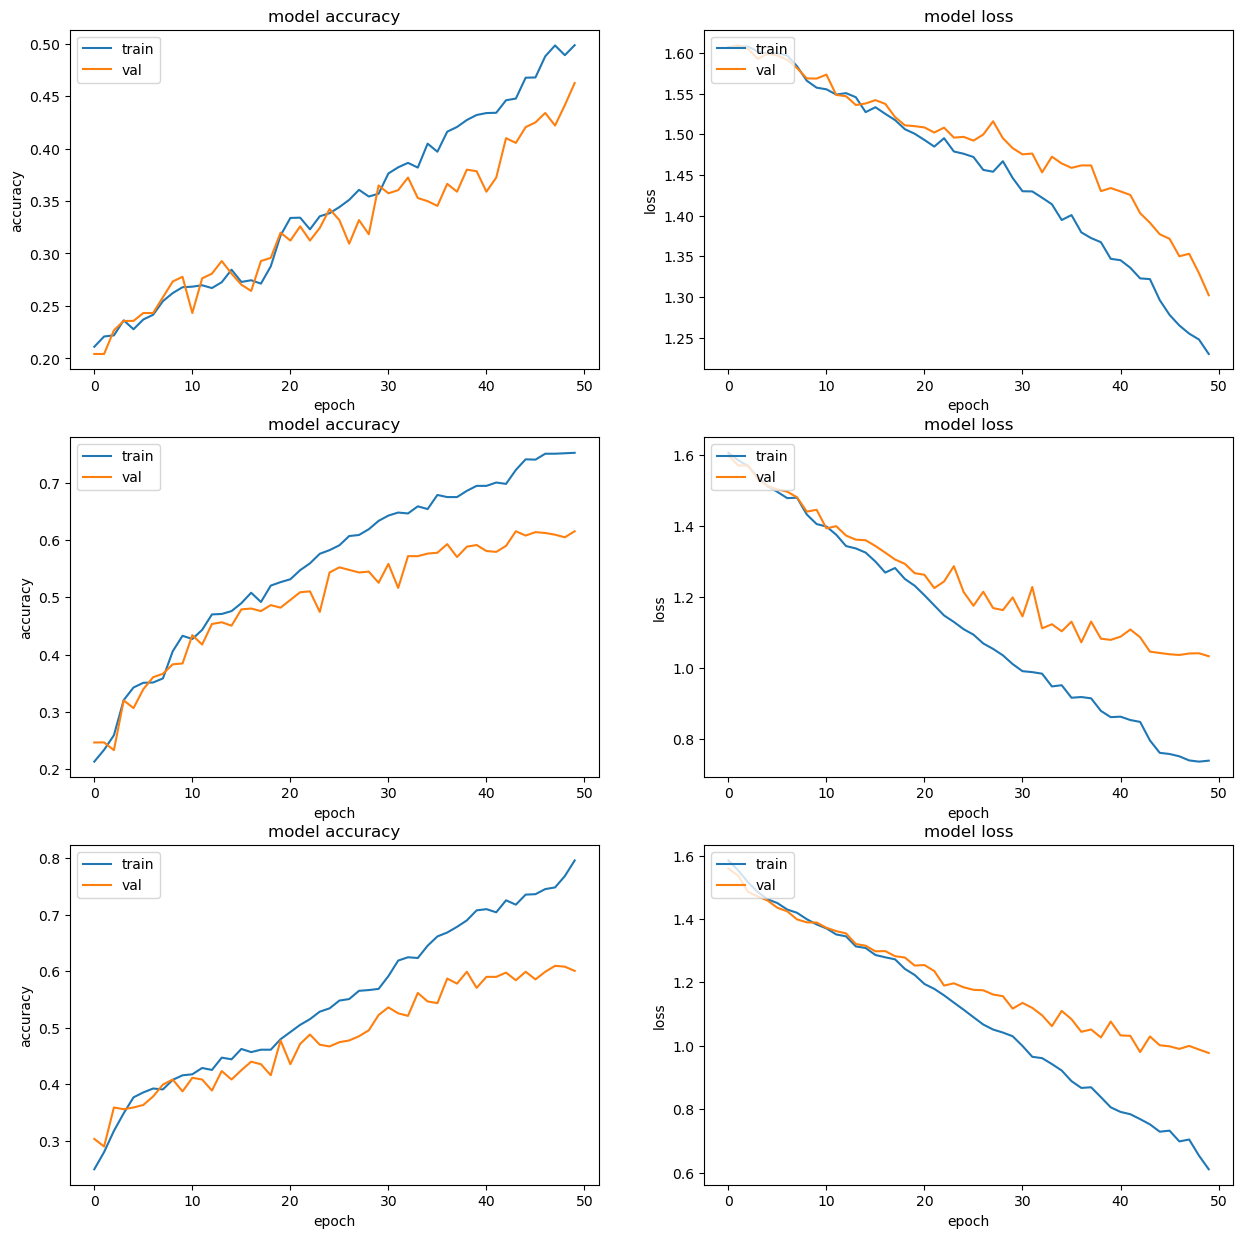

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.5978 - accuracy: 0.2394 - val_loss: 1.5701 - val_accuracy: 0.2988
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5497 - accuracy: 0.2878 - val_loss: 1.5457 - val_accuracy: 0.3003
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5194 - accuracy: 0.3042 - val_loss: 1.5023 - val_accuracy: 0.3348
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4754 - accuracy: 0.3419 - val_loss: 1.4581 - val_accuracy: 0.3423
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4345 - accuracy: 0.3761 - val_loss: 1.4466 - val_accuracy: 0.3739
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4185 - accuracy: 0.4084 - val_loss: 1.4196 - val_accuracy: 0.3649
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.3607 - accuracy: 0.4308 - val_loss: 1.3788 - val_accuracy: 0.4339

118/118 [==============================] - 2s 14ms/step - loss: 1.6064 - accuracy: 0.2282 - val_loss: 1.6079 - val_accuracy: 0.2192
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6070 - accuracy: 0.2295 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 8/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6081 - accuracy: 0.2205 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 9/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6079 - accuracy: 0.2247 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 10/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6076 - accuracy: 0.2189 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 11/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6081 - accuracy: 0.2160 - val_loss: 1.6078 - val_accuracy: 0.2192

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/50
118/118 [==============================] - 2s 15ms/step -

16/16 [==============================] - 0s 5ms/step - loss: 1.6079 - accuracy: 0.2186
test loss, test acc: [1.6078506708145142, 0.21862348914146423]
Test set results:[[1.1342755556106567, 0.52226722240448], [1.6078517436981201, 0.21862348914146423], [1.6078506708145142, 0.21862348914146423]]
Average loss:1.4499926567077637
Average accuracy:0.3198380668958028


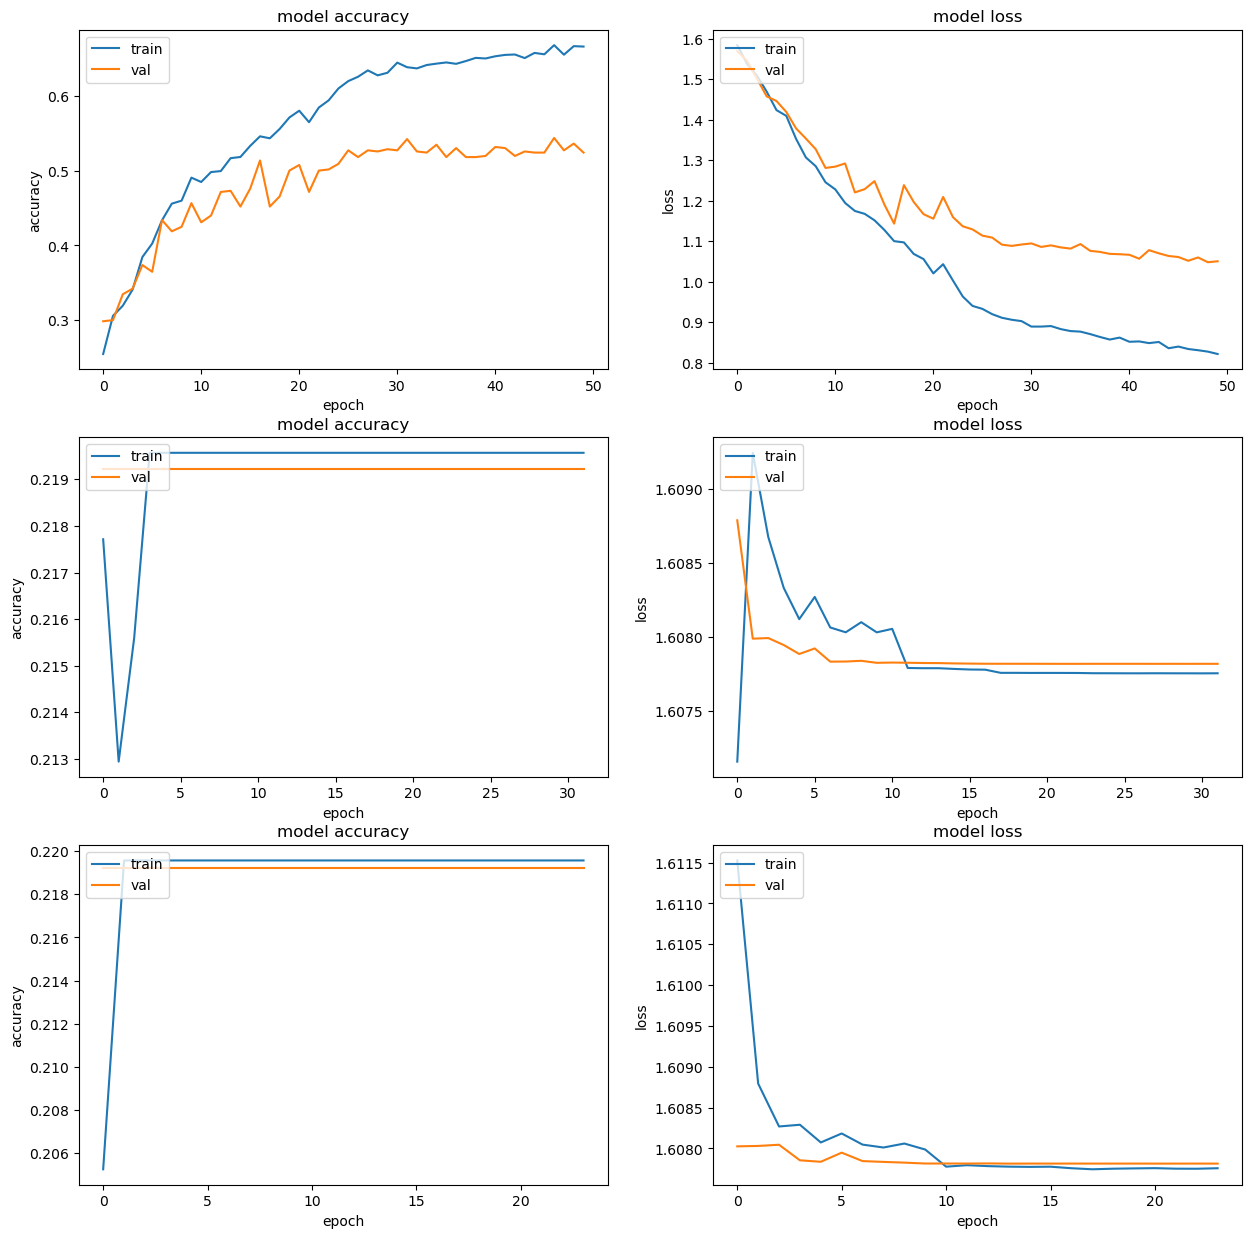

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.5980 - accuracy: 0.2230 - val_loss: 1.5532 - val_accuracy: 0.2718
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5384 - accuracy: 0.2761 - val_loss: 1.5422 - val_accuracy: 0.3303
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5386 - accuracy: 0.3132 - val_loss: 1.5163 - val_accuracy: 0.3784
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5029 - accuracy: 0.3668 - val_loss: 1.4955 - val_accuracy: 0.3709
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4740 - accuracy: 0.3807 - val_loss: 1.4832 - val_accuracy: 0.3559
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4607 - accuracy: 0.3700 - val_loss: 1.4687 - val_accuracy: 0.3544
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.4390 - accuracy: 0.3897 - val_loss: 1.4471 - val_accuracy: 0.3844

Epoch 7/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6078 - accuracy: 0.2188 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 8/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6073 - accuracy: 0.2245 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 9/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6079 - accuracy: 0.2210 - val_loss: 1.6078 - val_accuracy: 0.2192

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6073 - accuracy: 0.2264 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 11/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6071 - accuracy: 0.2305 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 12/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6081 - accuracy: 0.2221 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 13/50
118/118 [==============================] - 2s

16/16 [==============================] - 0s 5ms/step - loss: 1.6078 - accuracy: 0.2186
test loss, test acc: [1.6078470945358276, 0.21862348914146423]
Test set results:[[1.0392521619796753, 0.5931174159049988], [1.6078548431396484, 0.21862348914146423], [1.6078470945358276, 0.21862348914146423]]
Average loss:1.4183180332183838
Average accuracy:0.3434547980626424


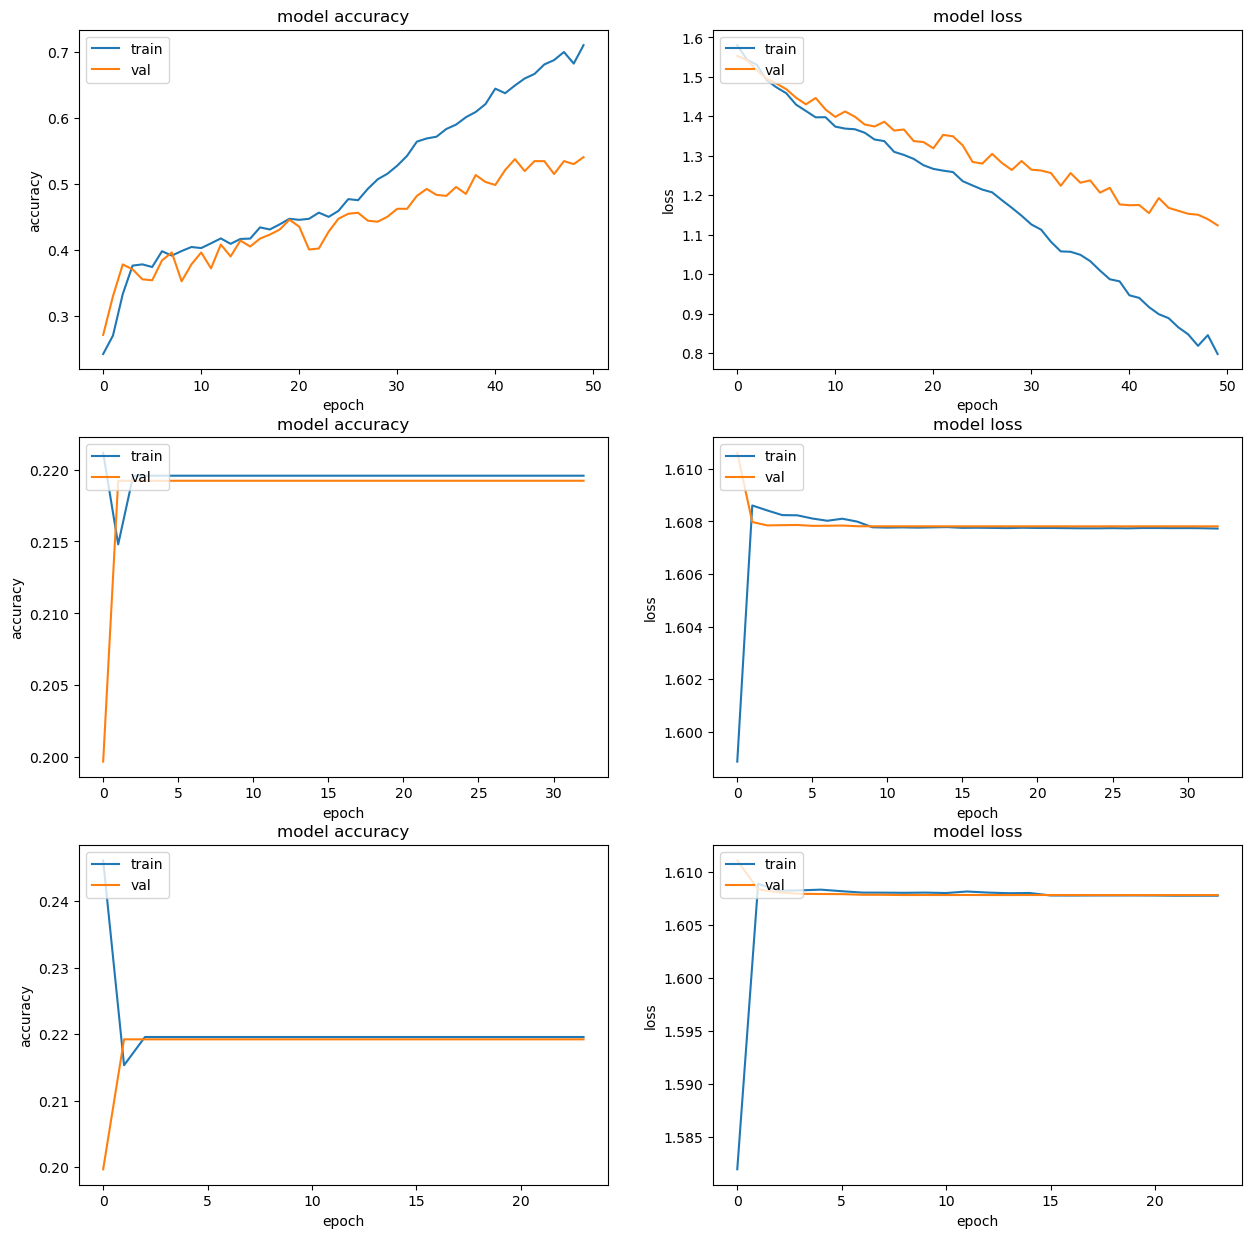

Epoch 1/50
118/118 [==============================] - 3s 18ms/step - loss: 1.6117 - accuracy: 0.1922 - val_loss: 1.6065 - val_accuracy: 0.2237
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6074 - accuracy: 0.2133 - val_loss: 1.6034 - val_accuracy: 0.2117
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5971 - accuracy: 0.2263 - val_loss: 1.5979 - val_accuracy: 0.2402
Epoch 4/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5910 - accuracy: 0.2422 - val_loss: 1.6183 - val_accuracy: 0.2222
Epoch 5/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6014 - accuracy: 0.2240 - val_loss: 1.6019 - val_accuracy: 0.2207
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5792 - accuracy: 0.2313 - val_loss: 1.5938 - val_accuracy: 0.2387
Epoch 7/50
118/118 [==============================] - 2s 15ms/step - loss: 1.5740 - accuracy: 0.2402 - val_loss: 1.5890 - val_accuracy: 0.2297

118/118 [==============================] - 2s 15ms/step - loss: 1.6086 - accuracy: 0.2183 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 9/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.2136 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 10/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6071 - accuracy: 0.2238 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 11/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6071 - accuracy: 0.2268 - val_loss: 1.6078 - val_accuracy: 0.2192

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.2119 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 13/50
118/118 [==============================] - 2s 15ms/step - loss: 1.6068 - accuracy: 0.2253 - val_loss: 1.6078 - val_accuracy: 0.2192
Epoch 14/50
118/118 [==============================] - 2s 15ms/step

118/118 [==============================] - 2s 15ms/step - loss: 0.7628 - accuracy: 0.7357 - val_loss: 1.3631 - val_accuracy: 0.4790
Epoch 47/50
118/118 [==============================] - 2s 15ms/step - loss: 0.7366 - accuracy: 0.7468 - val_loss: 1.3588 - val_accuracy: 0.4715
Epoch 48/50
118/118 [==============================] - 2s 15ms/step - loss: 0.7331 - accuracy: 0.7453 - val_loss: 1.3646 - val_accuracy: 0.4715
Epoch 49/50
118/118 [==============================] - 2s 15ms/step - loss: 0.7035 - accuracy: 0.7559 - val_loss: 1.3610 - val_accuracy: 0.4760
Epoch 50/50
118/118 [==============================] - 2s 15ms/step - loss: 0.7173 - accuracy: 0.7563 - val_loss: 1.3366 - val_accuracy: 0.4760
Done
Evaluate on test data
16/16 [==============================] - 0s 5ms/step - loss: 1.3787 - accuracy: 0.4838
test loss, test acc: [1.3787052631378174, 0.48380565643310547]
Test set results:[[1.51275634765625, 0.30566802620887756], [1.6076533794403076, 0.22064776718616486], [1.3787052631

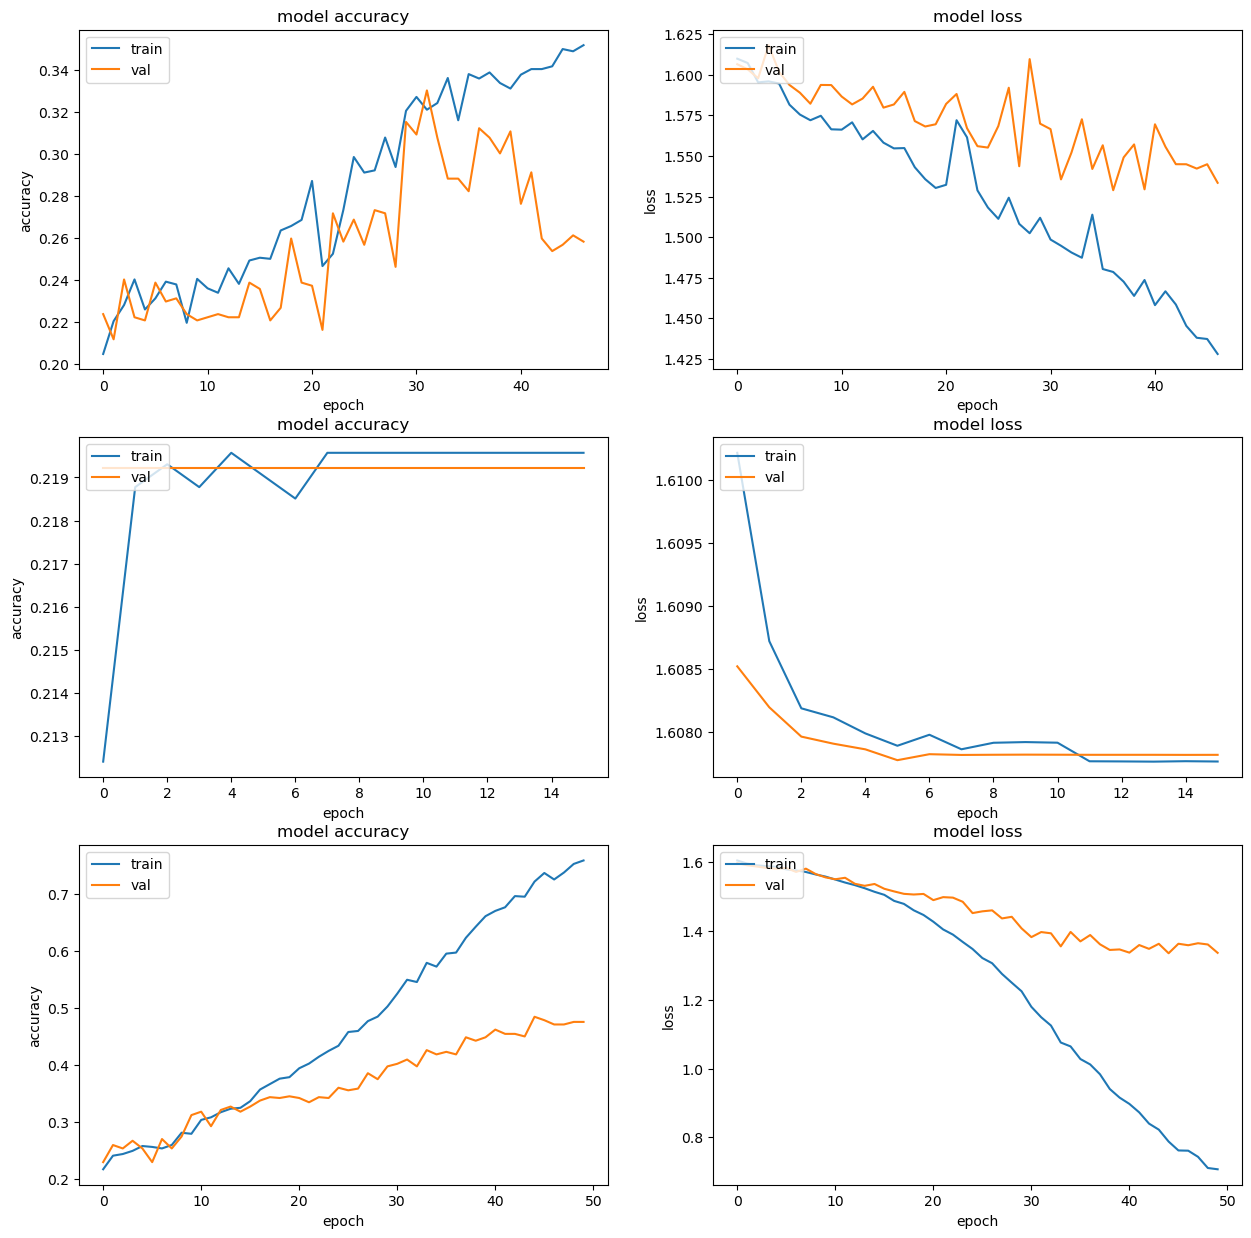

In [18]:
emovo2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# RAVDESS

In [19]:
metadata, data0, data1, data2, data3, y = load_data('ravdess')
metadata

path  \
0     /datasets/nicolas_facchinetti/ravdess/data/Act...   
1     /datasets/nicolas_facchinetti/ravdess/data/Act...   
2     /datasets/nicolas_facchinetti/ravdess/data/Act...   
3     /datasets/nicolas_facchinetti/ravdess/data/Act...   
4     /datasets/nicolas_facchinetti/ravdess/data/Act...   
...                                                 ...   
8947  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8948  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8949  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8950  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8951  /datasets/nicolas_facchinetti/ravdess/data/Act...   

                      filename  chunk      label     actor gender  mod  
0     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    0  
1     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
2     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
3     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
4     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
...                        ...    ...        ...       ...    ...  ...  
8947  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    1  
8948  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8949  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8950  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8951  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  

[8952 rows x 7 columns]

In [20]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 5))

## Without standardization

Epoch 1/50
214/214 [==============================] - 5s 17ms/step - loss: 1.5696 - accuracy: 0.2759 - val_loss: 1.5299 - val_accuracy: 0.2920
Epoch 2/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5294 - accuracy: 0.3167 - val_loss: 1.5284 - val_accuracy: 0.3209
Epoch 3/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5051 - accuracy: 0.3452 - val_loss: 1.4810 - val_accuracy: 0.3755
Epoch 4/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4929 - accuracy: 0.3366 - val_loss: 1.4706 - val_accuracy: 0.3424
Epoch 5/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4709 - accuracy: 0.3536 - val_loss: 1.4804 - val_accuracy: 0.3474
Epoch 6/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4553 - accuracy: 0.3741 - val_loss: 1.4454 - val_accuracy: 0.3838
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4409 - accuracy: 0.3827 - val_loss: 1.4166 - val_accuracy: 0.4177

214/214 [==============================] - 3s 15ms/step - loss: 1.5092 - accuracy: 0.3250 - val_loss: 1.4854 - val_accuracy: 0.3490
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4903 - accuracy: 0.3512 - val_loss: 1.4855 - val_accuracy: 0.3499
Epoch 8/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4854 - accuracy: 0.3463 - val_loss: 1.4813 - val_accuracy: 0.3540
Epoch 9/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4743 - accuracy: 0.3664 - val_loss: 1.4673 - val_accuracy: 0.3615
Epoch 10/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4607 - accuracy: 0.3635 - val_loss: 1.4651 - val_accuracy: 0.3639
Epoch 11/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4754 - accuracy: 0.3564 - val_loss: 1.5053 - val_accuracy: 0.3400
Epoch 12/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4733 - accuracy: 0.3567 - val_loss: 1.4941 - val_accuracy: 0.3400
Epoch 1

214/214 [==============================] - 3s 15ms/step - loss: 1.4574 - accuracy: 0.3644 - val_loss: 1.4292 - val_accuracy: 0.3912
Epoch 12/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3716 - accuracy: 0.4149 - val_loss: 1.3966 - val_accuracy: 0.3978
Epoch 13/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3389 - accuracy: 0.4310 - val_loss: 1.3760 - val_accuracy: 0.3962
Epoch 14/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3066 - accuracy: 0.4503 - val_loss: 1.3676 - val_accuracy: 0.3970
Epoch 15/50
214/214 [==============================] - 3s 15ms/step - loss: 1.2908 - accuracy: 0.4488 - val_loss: 1.3777 - val_accuracy: 0.4202
Epoch 16/50
214/214 [==============================] - 3s 15ms/step - loss: 1.2710 - accuracy: 0.4751 - val_loss: 1.3471 - val_accuracy: 0.4409
Epoch 17/50
214/214 [==============================] - 3s 15ms/step - loss: 1.2631 - accuracy: 0.4725 - val_loss: 1.3656 - val_accuracy: 0.4285
Epoc

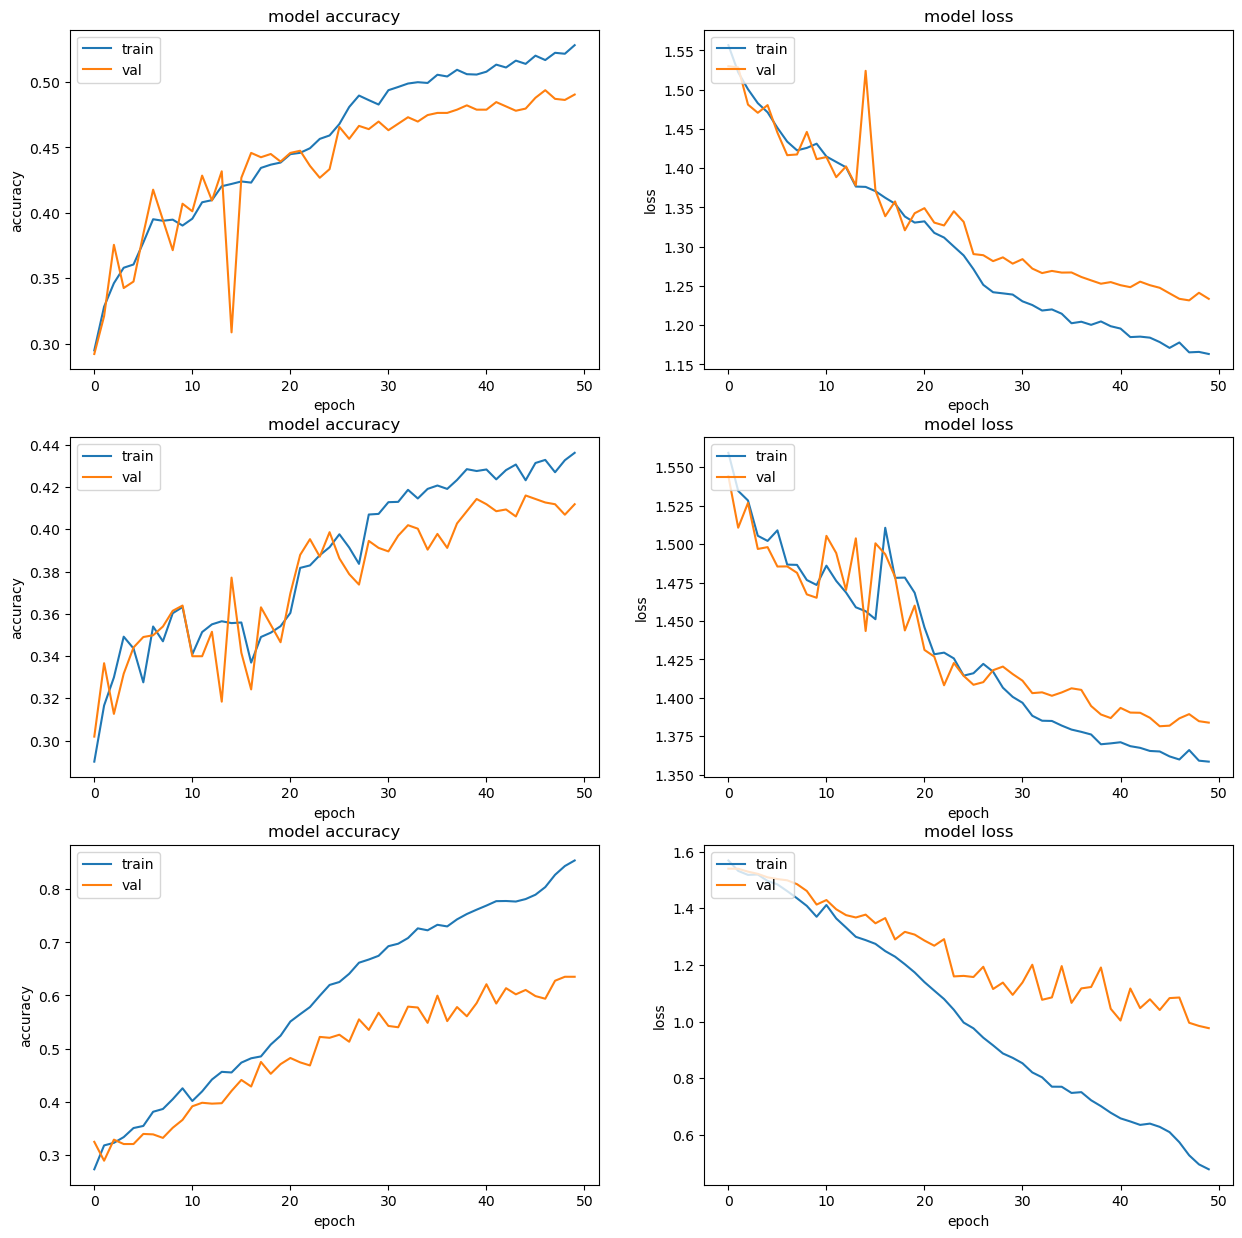

Epoch 1/50
214/214 [==============================] - 5s 16ms/step - loss: 1.6098 - accuracy: 0.1855 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 2/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2065 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 3/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2103 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 4/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6097 - accuracy: 0.2031 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 5/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6089 - accuracy: 0.2079 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 6/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2125 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 7/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2020 - val_loss: 1.6092 - val_accuracy: 0.2068

214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2059 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 31/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2135 - val_loss: 1.6092 - val_accuracy: 0.2068

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 32/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6086 - accuracy: 0.2043 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 33/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2036 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 34/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2025 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 35/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2041 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 36/50
214/214 [==============================] - 3s 14ms/step

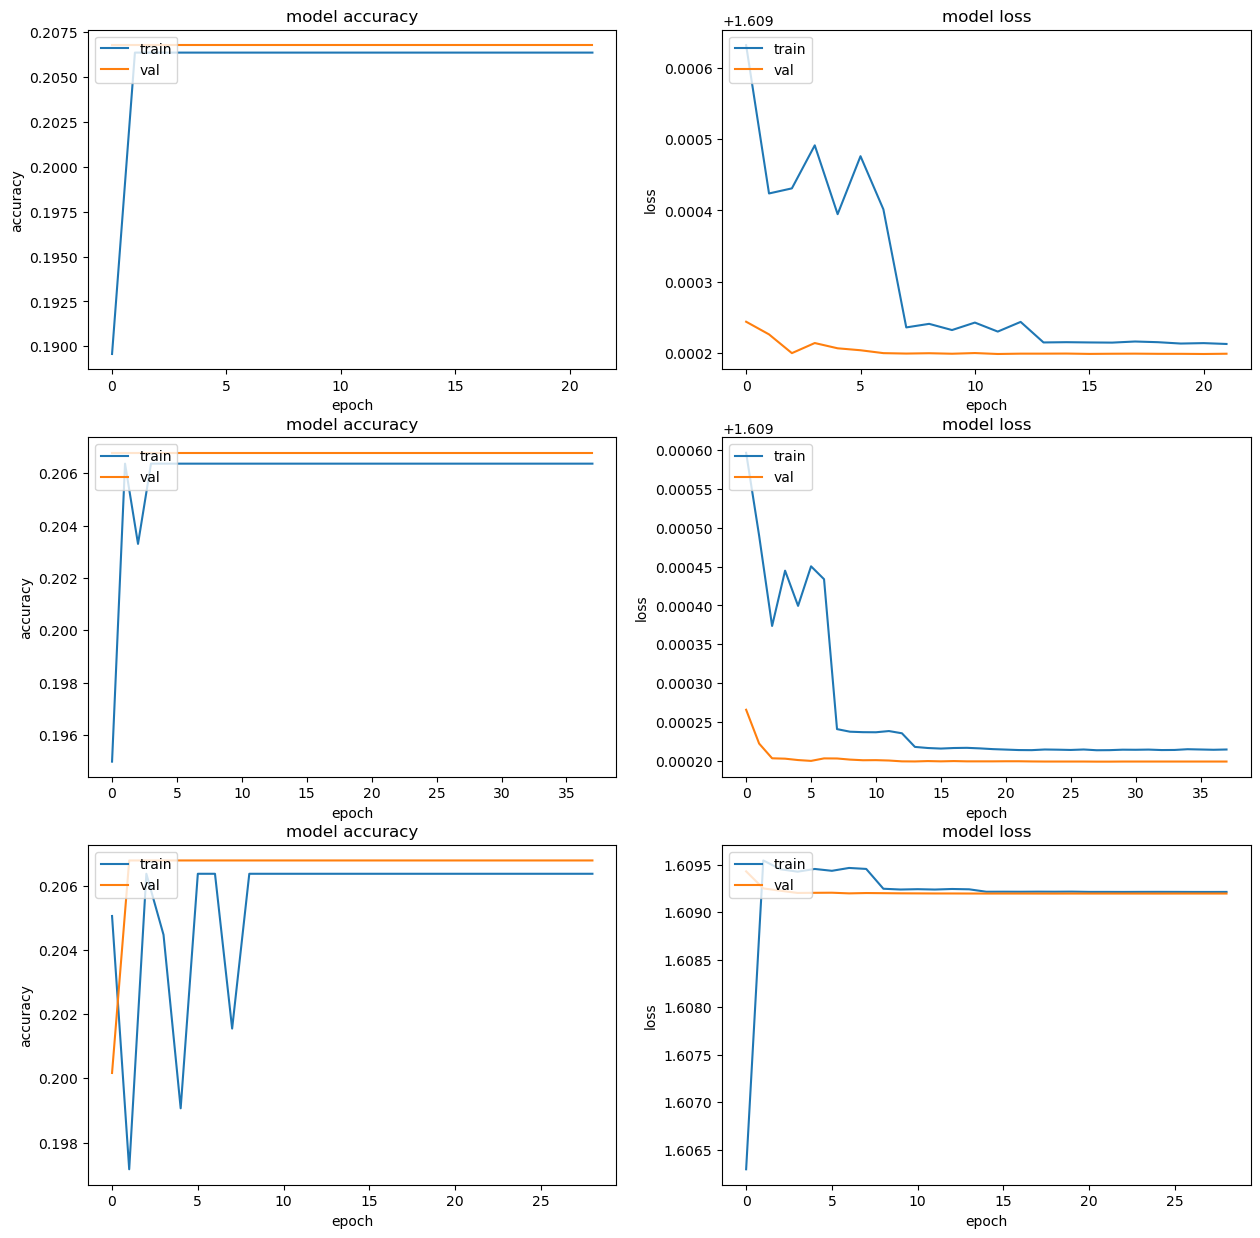

Epoch 1/50
214/214 [==============================] - 5s 17ms/step - loss: 1.6039 - accuracy: 0.2366 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 2/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2179 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 3/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2121 - val_loss: 1.6093 - val_accuracy: 0.2018
Epoch 4/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.1959 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 5/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2054 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 6/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6097 - accuracy: 0.1990 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 7/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2114 - val_loss: 1.6092 - val_accuracy: 0.2068

214/214 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2014 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 18/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2071 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 19/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2062 - val_loss: 1.6092 - val_accuracy: 0.2068

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6088 - accuracy: 0.2148 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 21/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2044 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 22/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2071 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 23/50
214/214 [==============================] - 3s 14ms/ste

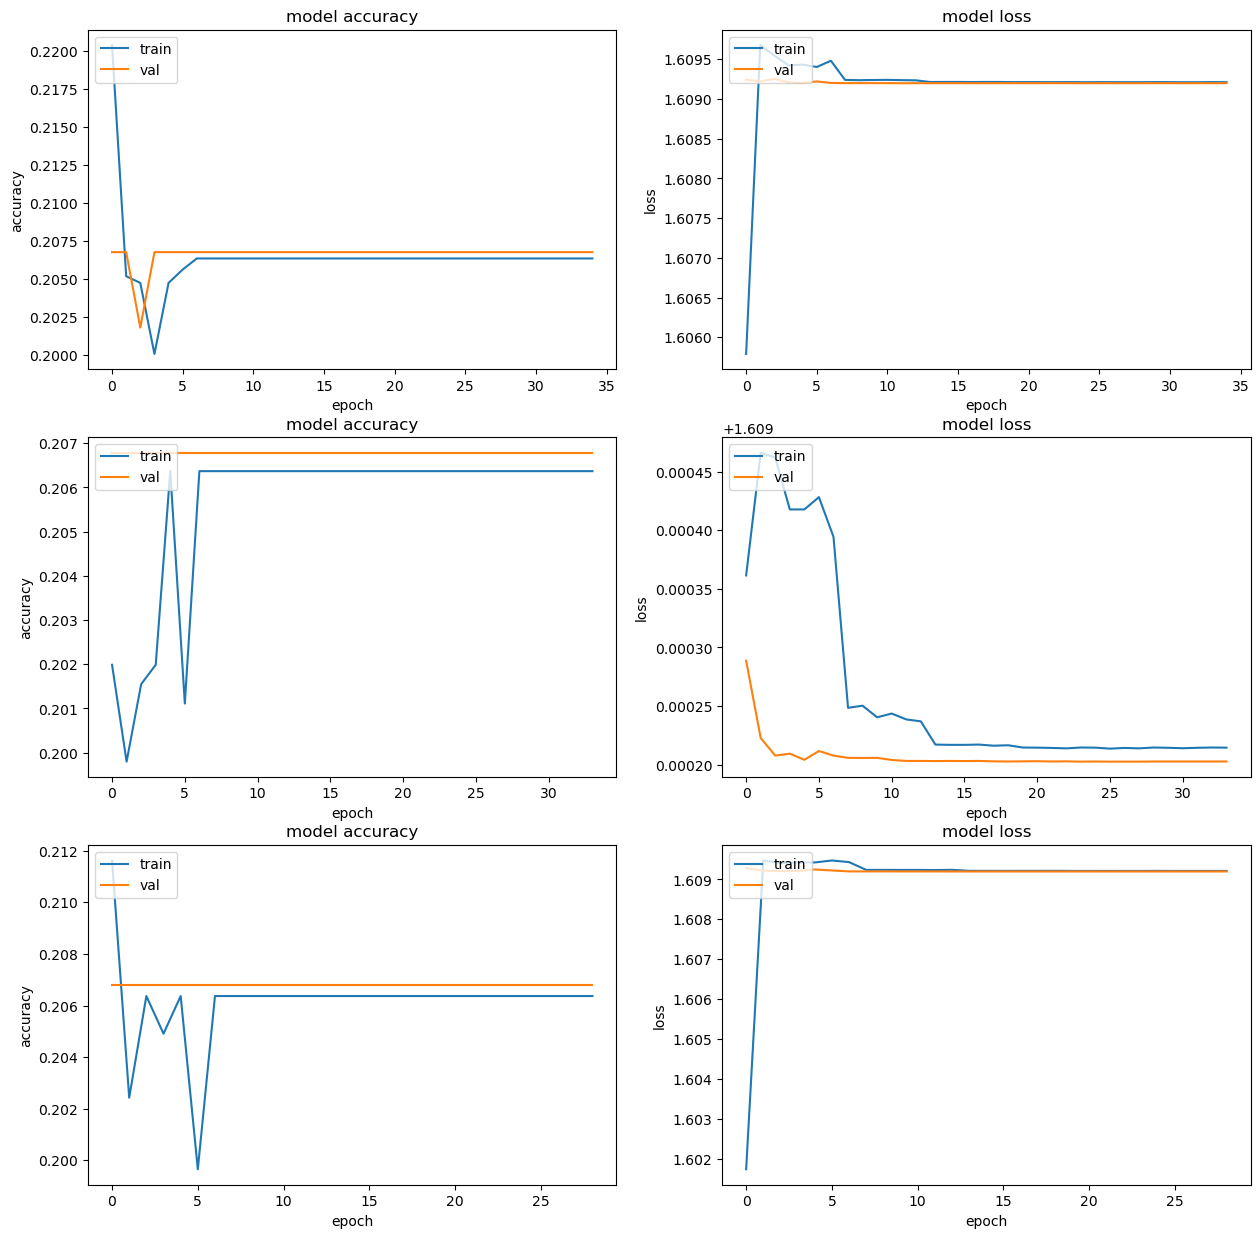

Epoch 1/50
214/214 [==============================] - 5s 16ms/step - loss: 1.6050 - accuracy: 0.2285 - val_loss: 1.6147 - val_accuracy: 0.2018
Epoch 2/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5812 - accuracy: 0.2611 - val_loss: 1.5686 - val_accuracy: 0.2514
Epoch 3/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5508 - accuracy: 0.2972 - val_loss: 1.5438 - val_accuracy: 0.3118
Epoch 4/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5192 - accuracy: 0.3353 - val_loss: 1.5277 - val_accuracy: 0.3449
Epoch 5/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4927 - accuracy: 0.3604 - val_loss: 1.4776 - val_accuracy: 0.3681
Epoch 6/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4537 - accuracy: 0.3946 - val_loss: 1.4344 - val_accuracy: 0.3962
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3977 - accuracy: 0.4373 - val_loss: 1.3775 - val_accuracy: 0.4227

214/214 [==============================] - 3s 15ms/step - loss: 0.7413 - accuracy: 0.7542 - val_loss: 1.0139 - val_accuracy: 0.6129
Epoch 18/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6762 - accuracy: 0.7879 - val_loss: 0.9673 - val_accuracy: 0.6518
Epoch 19/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6541 - accuracy: 0.7934 - val_loss: 1.0183 - val_accuracy: 0.6253
Epoch 20/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6213 - accuracy: 0.7983 - val_loss: 1.0123 - val_accuracy: 0.6352
Epoch 21/50
214/214 [==============================] - 3s 15ms/step - loss: 0.5972 - accuracy: 0.8082 - val_loss: 0.9582 - val_accuracy: 0.6427
Epoch 22/50
214/214 [==============================] - 3s 15ms/step - loss: 0.5620 - accuracy: 0.8221 - val_loss: 0.9729 - val_accuracy: 0.6460
Epoch 23/50
214/214 [==============================] - 3s 15ms/step - loss: 0.5449 - accuracy: 0.8224 - val_loss: 0.9852 - val_accuracy: 0.6468
Epoc

214/214 [==============================] - 3s 15ms/step - loss: 0.4371 - accuracy: 0.8817 - val_loss: 0.9905 - val_accuracy: 0.6294
Epoch 37/50
214/214 [==============================] - 3s 15ms/step - loss: 0.4085 - accuracy: 0.9020 - val_loss: 1.0038 - val_accuracy: 0.6245
Epoch 38/50
214/214 [==============================] - 3s 15ms/step - loss: 0.4090 - accuracy: 0.8973 - val_loss: 1.0049 - val_accuracy: 0.6228
Epoch 39/50
214/214 [==============================] - 3s 15ms/step - loss: 0.3926 - accuracy: 0.9069 - val_loss: 1.0100 - val_accuracy: 0.6170
Epoch 40/50
214/214 [==============================] - 3s 15ms/step - loss: 0.3919 - accuracy: 0.9045 - val_loss: 1.0022 - val_accuracy: 0.6336
Epoch 41/50
214/214 [==============================] - 3s 14ms/step - loss: 0.3747 - accuracy: 0.9180 - val_loss: 1.0142 - val_accuracy: 0.6311
Epoch 42/50
214/214 [==============================] - 3s 15ms/step - loss: 0.3937 - accuracy: 0.9015 - val_loss: 0.9981 - val_accuracy: 0.6261

Epo

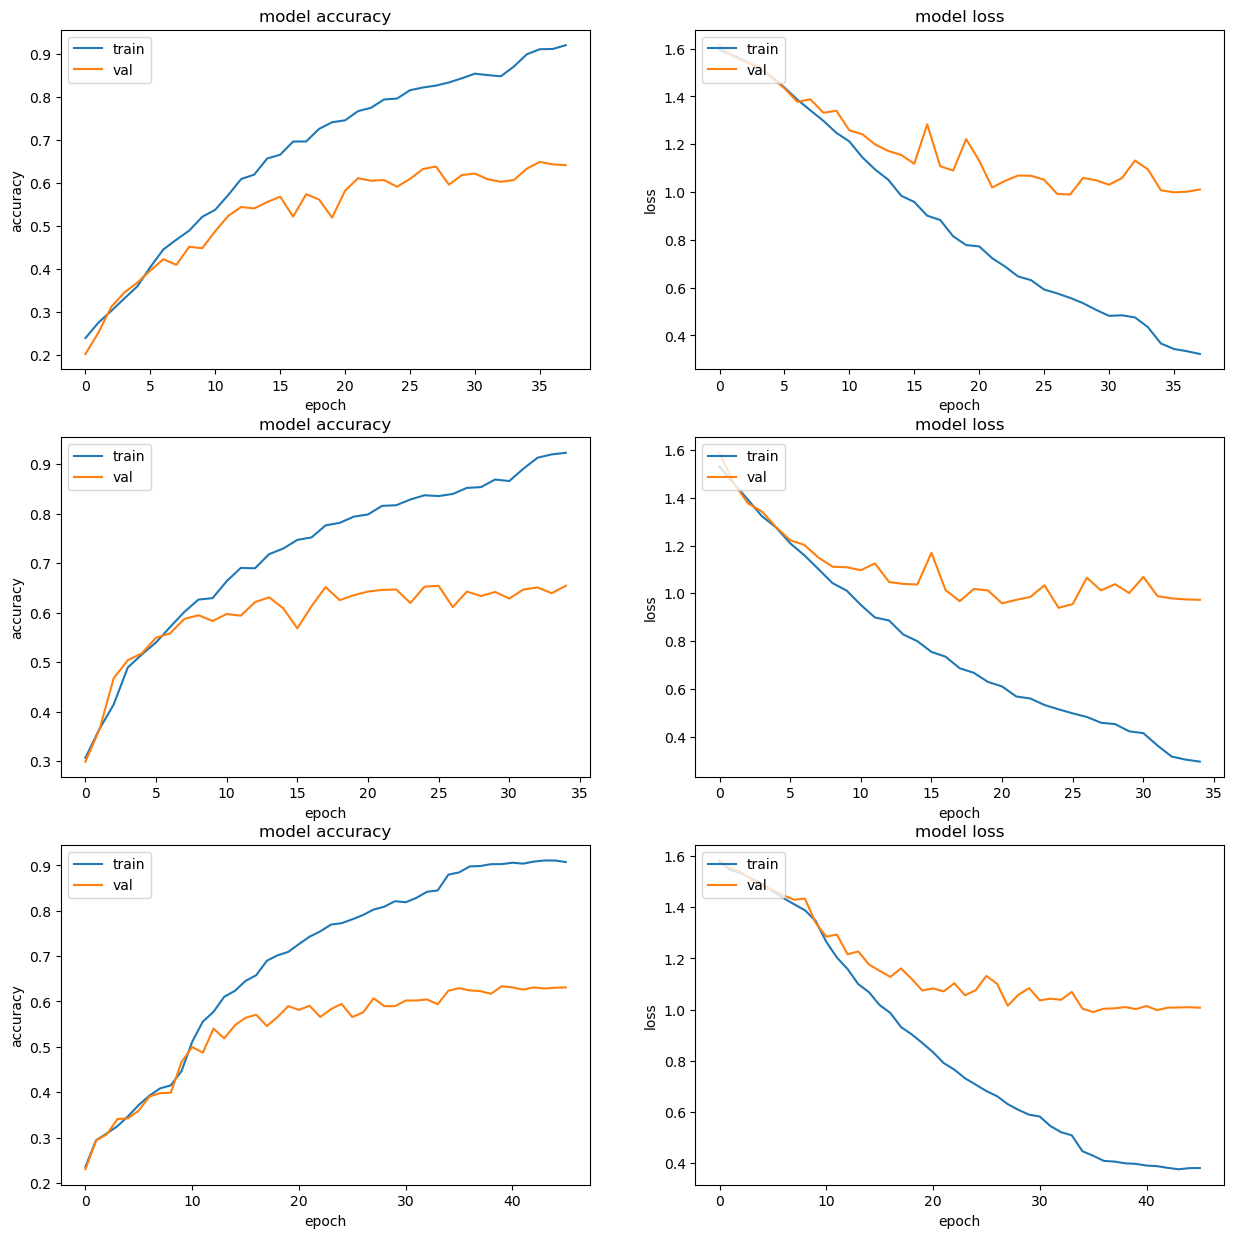

In [21]:
ravdess1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [22]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
214/214 [==============================] - 5s 16ms/step - loss: 1.6012 - accuracy: 0.2107 - val_loss: 1.5664 - val_accuracy: 0.2589
Epoch 2/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5556 - accuracy: 0.2721 - val_loss: 1.5634 - val_accuracy: 0.2506
Epoch 3/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5453 - accuracy: 0.2683 - val_loss: 1.5366 - val_accuracy: 0.2705
Epoch 4/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5366 - accuracy: 0.2839 - val_loss: 1.5442 - val_accuracy: 0.2787
Epoch 5/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5265 - accuracy: 0.2881 - val_loss: 1.5388 - val_accuracy: 0.2837
Epoch 6/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5288 - accuracy: 0.2920 - val_loss: 1.5273 - val_accuracy: 0.2787
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5210 - accuracy: 0.3029 - val_loss: 1.5375 - val_accuracy: 0.2878

214/214 [==============================] - 3s 15ms/step - loss: 1.2845 - accuracy: 0.4785 - val_loss: 1.3113 - val_accuracy: 0.4632
Epoch 13/50
214/214 [==============================] - 3s 15ms/step - loss: 1.2582 - accuracy: 0.4929 - val_loss: 1.3017 - val_accuracy: 0.4582
Epoch 14/50
214/214 [==============================] - 3s 14ms/step - loss: 1.2362 - accuracy: 0.5117 - val_loss: 1.2859 - val_accuracy: 0.4549
Epoch 15/50
214/214 [==============================] - 3s 15ms/step - loss: 1.2046 - accuracy: 0.5292 - val_loss: 1.2644 - val_accuracy: 0.4756
Epoch 16/50
214/214 [==============================] - 3s 15ms/step - loss: 1.1705 - accuracy: 0.5431 - val_loss: 1.2541 - val_accuracy: 0.4648
Epoch 17/50
214/214 [==============================] - 3s 15ms/step - loss: 1.1510 - accuracy: 0.5433 - val_loss: 1.1961 - val_accuracy: 0.5219
Epoch 18/50
214/214 [==============================] - 3s 15ms/step - loss: 1.1109 - accuracy: 0.5678 - val_loss: 1.1947 - val_accuracy: 0.5153
Epoc

214/214 [==============================] - 3s 15ms/step - loss: 0.8111 - accuracy: 0.7107 - val_loss: 1.0005 - val_accuracy: 0.6187
Epoch 18/50
214/214 [==============================] - 3s 15ms/step - loss: 0.7943 - accuracy: 0.7169 - val_loss: 0.9776 - val_accuracy: 0.6253
Epoch 19/50
214/214 [==============================] - 3s 15ms/step - loss: 0.7711 - accuracy: 0.7258 - val_loss: 0.9978 - val_accuracy: 0.6022
Epoch 20/50
214/214 [==============================] - 3s 15ms/step - loss: 0.7269 - accuracy: 0.7396 - val_loss: 0.9486 - val_accuracy: 0.6352
Epoch 21/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6828 - accuracy: 0.7544 - val_loss: 0.9457 - val_accuracy: 0.6476
Epoch 22/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6711 - accuracy: 0.7647 - val_loss: 1.0249 - val_accuracy: 0.6286
Epoch 23/50
214/214 [==============================] - 3s 15ms/step - loss: 0.6538 - accuracy: 0.7706 - val_loss: 0.9222 - val_accuracy: 0.6485
Epoc

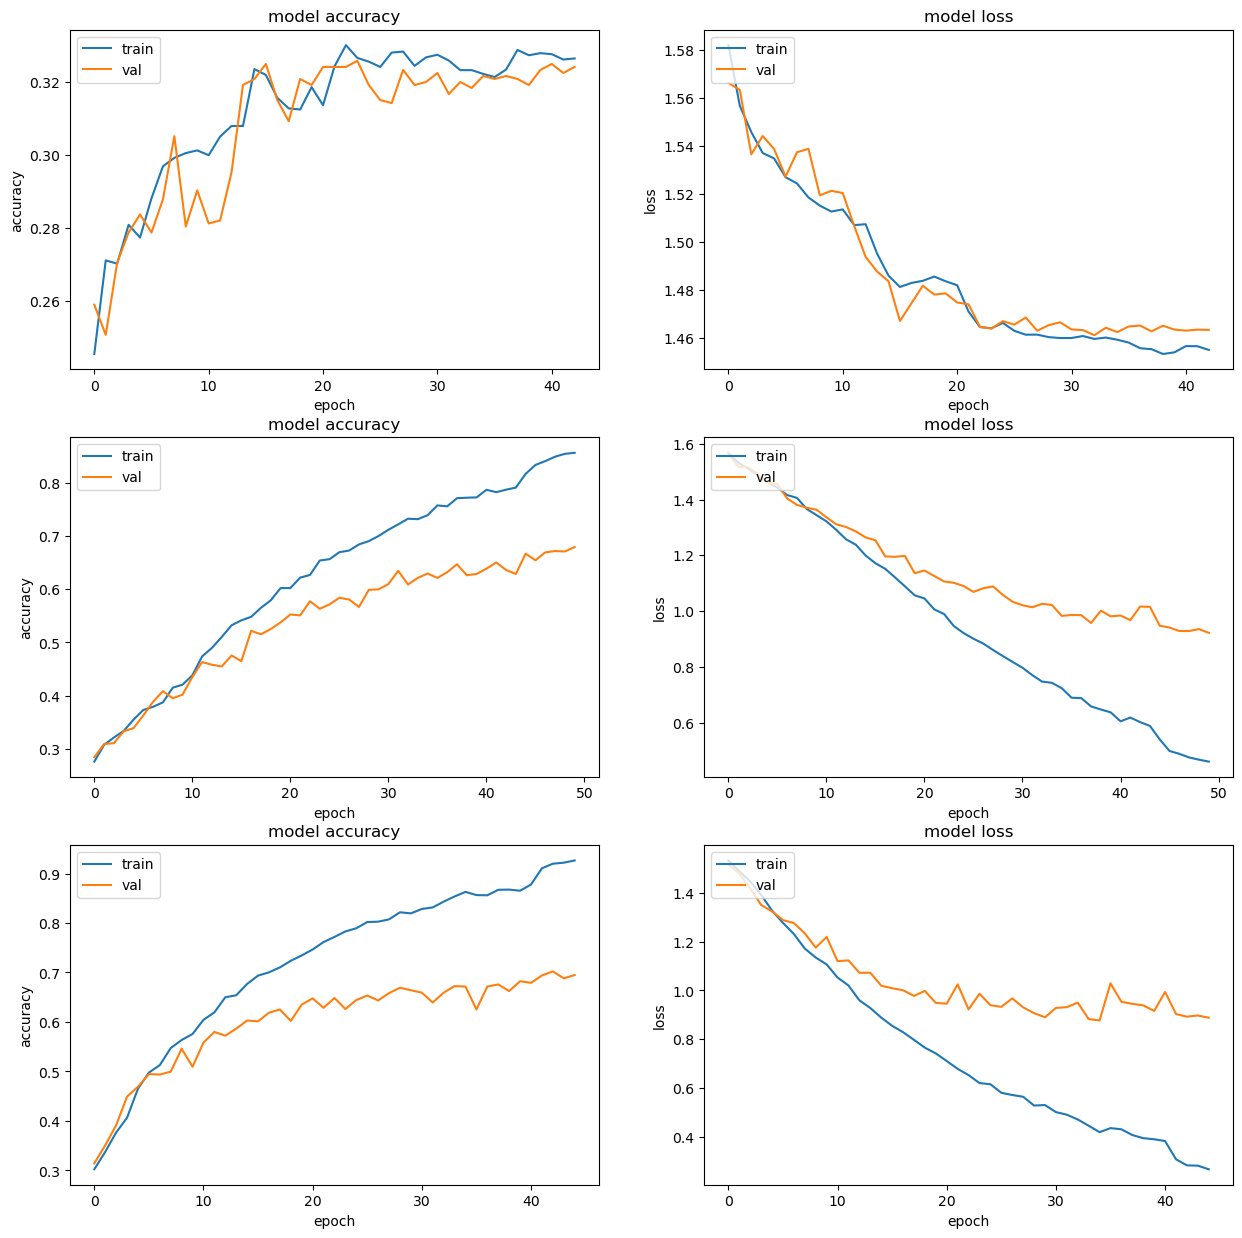

Epoch 1/50
214/214 [==============================] - 5s 16ms/step - loss: 1.5835 - accuracy: 0.2288 - val_loss: 1.6098 - val_accuracy: 0.2002
Epoch 2/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2008 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 3/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2038 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 4/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.1997 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 5/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2027 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 6/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2084 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 7/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2069 - val_loss: 1.6092 - val_accuracy: 0.2068

214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.1997 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 18/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2077 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 19/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2053 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 20/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2032 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 21/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2028 - val_loss: 1.6092 - val_accuracy: 0.2068

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 22/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6089 - accuracy: 0.2060 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 23/50
214/214 [==============================] - 3s 14ms/ste

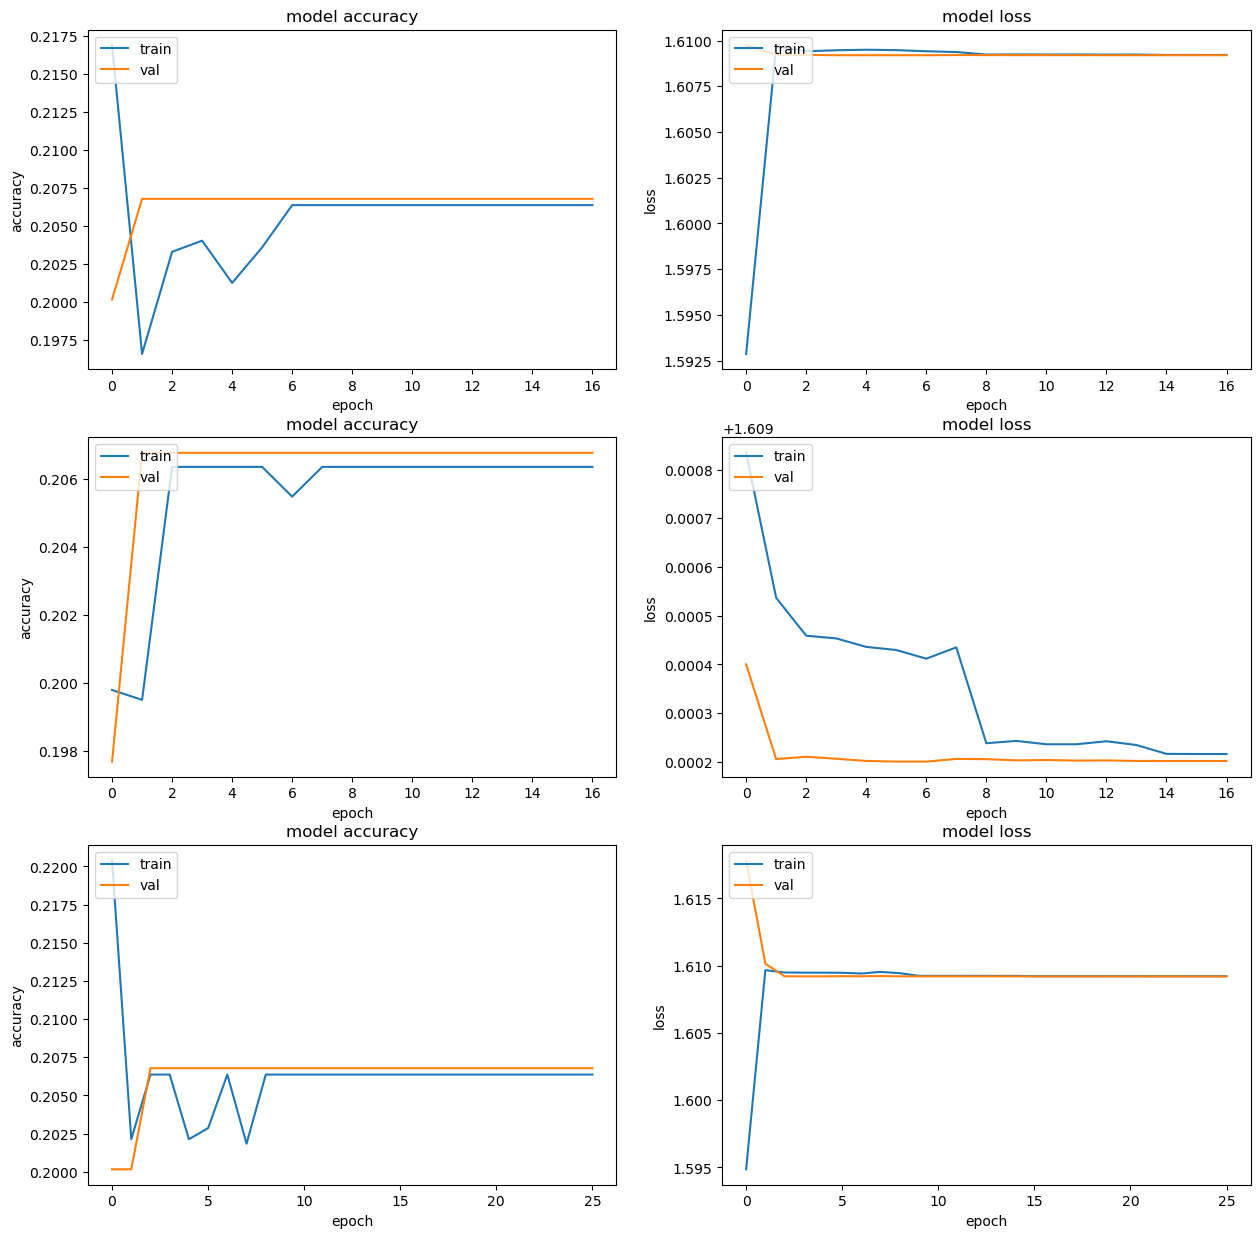

Epoch 1/50
214/214 [==============================] - 5s 16ms/step - loss: 1.6010 - accuracy: 0.2170 - val_loss: 1.6093 - val_accuracy: 0.2068
Epoch 2/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2084 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 3/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2141 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 4/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2111 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 5/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2059 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 6/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6099 - accuracy: 0.1972 - val_loss: 1.6093 - val_accuracy: 0.2068
Epoch 7/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2127 - val_loss: 1.6092 - val_accuracy: 0.2068

214/214 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2073 - val_loss: 1.6092 - val_accuracy: 0.2068

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 21/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6097 - accuracy: 0.1992 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 22/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2003 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 23/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2062 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 24/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2115 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 25/50
214/214 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2085 - val_loss: 1.6092 - val_accuracy: 0.2068
Epoch 26/50
214/214 [==============================] - 3s 14ms/ste

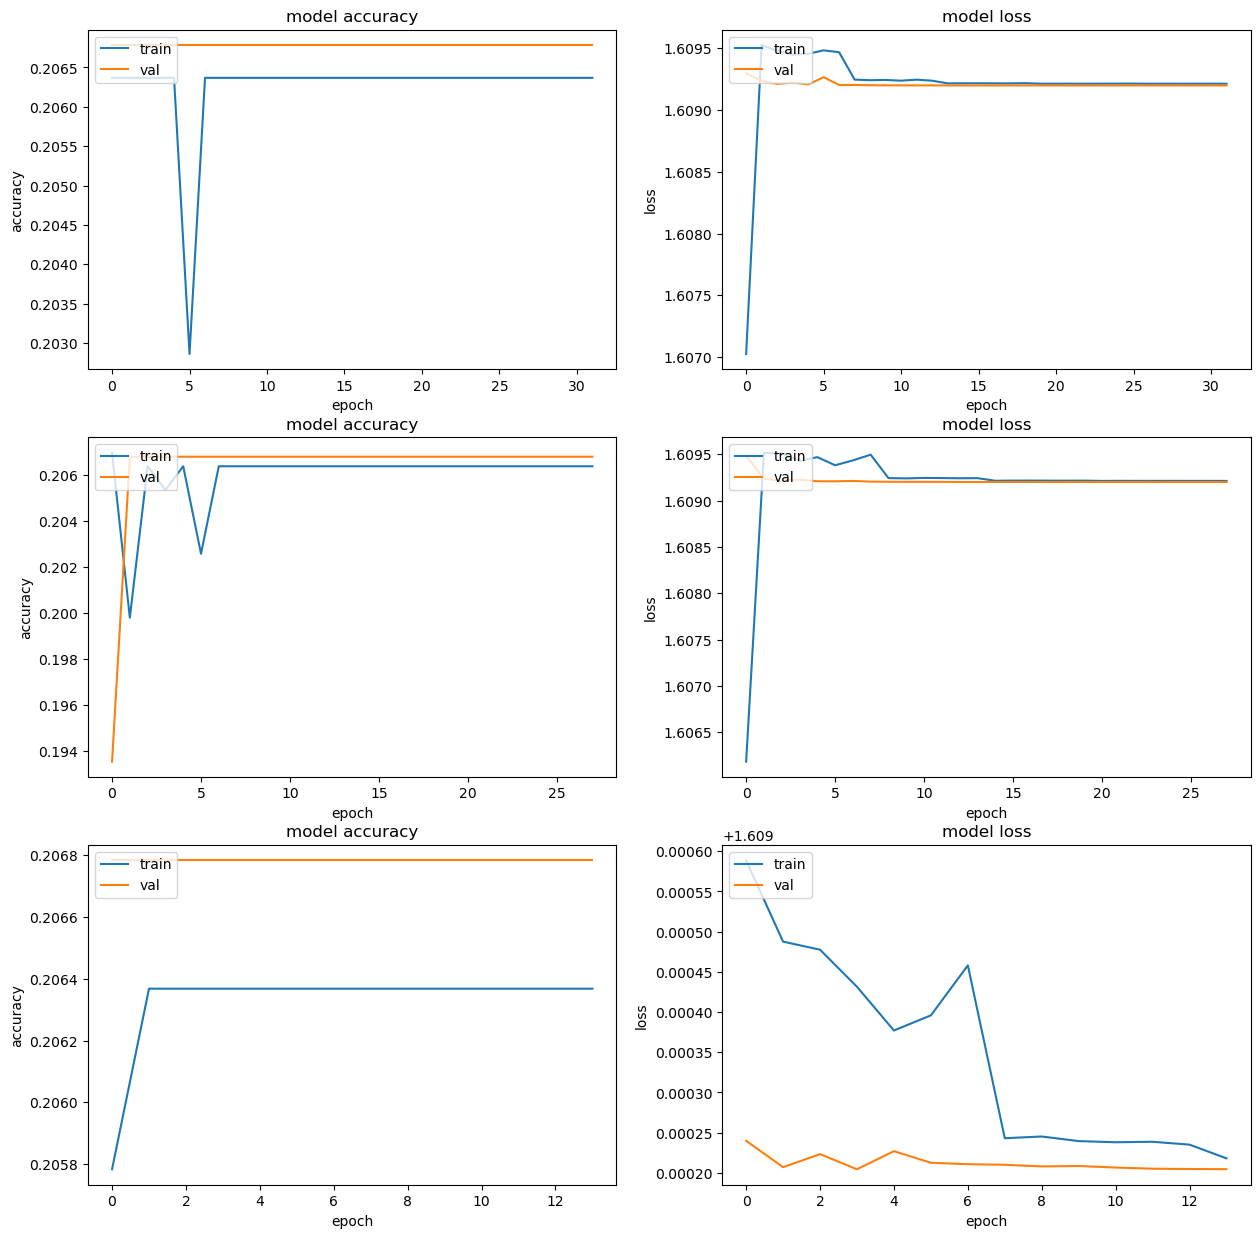

Epoch 1/50
214/214 [==============================] - 5s 17ms/step - loss: 1.5833 - accuracy: 0.2570 - val_loss: 1.5611 - val_accuracy: 0.2498
Epoch 2/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5621 - accuracy: 0.2807 - val_loss: 1.5497 - val_accuracy: 0.2837
Epoch 3/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5449 - accuracy: 0.2926 - val_loss: 1.5355 - val_accuracy: 0.2961
Epoch 4/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5354 - accuracy: 0.2955 - val_loss: 1.5327 - val_accuracy: 0.3002
Epoch 5/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5276 - accuracy: 0.3083 - val_loss: 1.5221 - val_accuracy: 0.3242
Epoch 6/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5125 - accuracy: 0.3219 - val_loss: 1.5116 - val_accuracy: 0.3581
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.5066 - accuracy: 0.3400 - val_loss: 1.4959 - val_accuracy: 0.3722

214/214 [==============================] - 3s 15ms/step - loss: 1.5005 - accuracy: 0.3292 - val_loss: 1.4825 - val_accuracy: 0.3317
Epoch 7/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4917 - accuracy: 0.3393 - val_loss: 1.4788 - val_accuracy: 0.3490
Epoch 8/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4711 - accuracy: 0.3571 - val_loss: 1.4558 - val_accuracy: 0.3730
Epoch 9/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4439 - accuracy: 0.3857 - val_loss: 1.4348 - val_accuracy: 0.3987
Epoch 10/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4285 - accuracy: 0.3963 - val_loss: 1.4198 - val_accuracy: 0.4078
Epoch 11/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3942 - accuracy: 0.4109 - val_loss: 1.4198 - val_accuracy: 0.3987
Epoch 12/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3695 - accuracy: 0.4285 - val_loss: 1.3824 - val_accuracy: 0.4235
Epoch 1

214/214 [==============================] - 3s 15ms/step - loss: 1.4364 - accuracy: 0.3559 - val_loss: 1.4425 - val_accuracy: 0.3499
Epoch 12/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4294 - accuracy: 0.3624 - val_loss: 1.4648 - val_accuracy: 0.3317
Epoch 13/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4465 - accuracy: 0.3510 - val_loss: 1.4392 - val_accuracy: 0.3482
Epoch 14/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4176 - accuracy: 0.3567 - val_loss: 1.4139 - val_accuracy: 0.3730
Epoch 15/50
214/214 [==============================] - 3s 15ms/step - loss: 1.4215 - accuracy: 0.3649 - val_loss: 1.4060 - val_accuracy: 0.3648
Epoch 16/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3936 - accuracy: 0.3808 - val_loss: 1.4021 - val_accuracy: 0.3573
Epoch 17/50
214/214 [==============================] - 3s 15ms/step - loss: 1.3855 - accuracy: 0.3819 - val_loss: 1.3910 - val_accuracy: 0.3863
Epoc

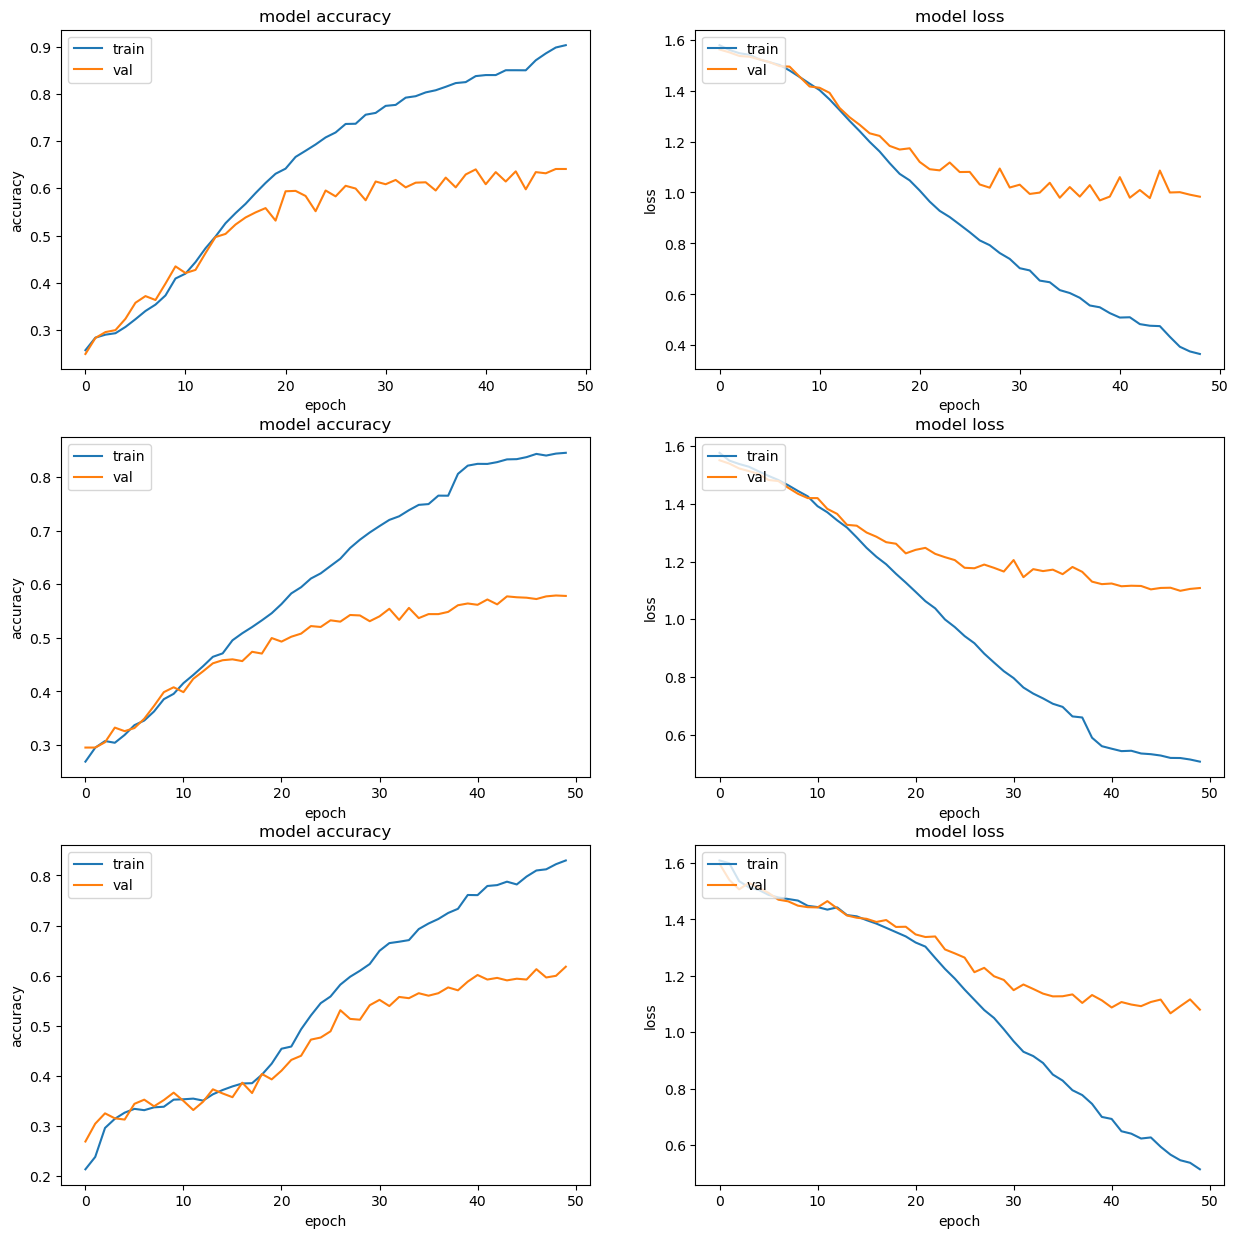

In [23]:
ravdess2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# Results comparison

In [24]:
def get_mean_acc(p):
    acc = [[test[1][1] for test in exp ] for exp in p]
    return np.asarray([np.mean(exp) for exp in acc])

In [25]:
get_mean_acc(emodb1)

array([0.73244443, 0.52711113, 0.78666665, 0.54488888])

In [26]:
get_mean_acc(emodb2)

array([0.51022222, 0.71555557, 0.71644445, 0.54844444])

In [27]:
np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2)))

array([0.73244443, 0.52711113, 0.78666665, 0.54488888, 0.51022222,
       0.71555557, 0.71644445, 0.54844444])

In [28]:
index = ['original', 'norm1', 'norm2', 'norm3', 'original std', 'norm1 std', 'norm2 std', 'norm3 std']

In [29]:
union = pd.concat([pd.DataFrame(np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2))), columns=['emodb'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(emovo1), get_mean_acc(emovo2))), columns=['emovo'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(ravdess1), get_mean_acc(ravdess2))), columns=['ravdess'], index=index)
                  ], axis=1)

In [30]:
union['mean'] = union.mean(axis=1)

In [31]:
union

emodb     emovo   ravdess      mean
original      0.732444  0.390688  0.504836  0.542656
norm1         0.527111  0.278677  0.206473  0.337421
norm2         0.786667  0.358300  0.206473  0.450480
norm3         0.544889  0.480432  0.600446  0.541922
original std  0.510222  0.569501  0.555432  0.545051
norm1 std     0.715556  0.319838  0.206473  0.413956
norm2 std     0.716444  0.343455  0.206473  0.422124
norm3 std     0.548444  0.336707  0.606027  0.497059